In [1]:
from hossam import load_data
from matplotlib import pyplot as plt
from matplotlib import font_manager as fm
import seaborn as sb
import numpy as np
import pandas as pd
from pandas import DataFrame

import statsmodels.api as sm
from statsmodels.stats.diagnostic import linear_reset
from scipy.stats import zscore, probplot, shapiro, anderson
from statsmodels.stats.api import het_breuschpagan
from statsmodels.stats.stattools import durbin_watson
from scipy.stats import spearmanr

from itertools import combinations
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [30]:
my_dpi = 200
font_path = "../data_visualization/NotoSansKR-Regular.ttf"
fm.fontManager.addfont(font_path)
font_prop = fm.FontProperties(fname=font_path)
font_name = font_prop.get_name()
my_font_name = "Noto Sans KR"
my_theme = "dark"

sb.set_theme(style=my_theme)
plt.rcParams['font.family'] = my_font_name
plt.rcParams['font.size'] = 5
plt.rcParams['axes.unicode_minus'] = False

In [3]:
origin = load_data('california_housing')

print("\n===== 데이터 크기 확인 =====")
print(f"데이터셋 크기 : {origin.shape}")
print(f"열 개수: {origin.shape[1]}")
print(f"행 개수: {origin.shape[0]}")

origin.head()

[data] https://data.hossam.kr/data/kaggle/california_housing.xlsx
[desc] 1990년 미국 인구조사(Census)를 기반으로 캘리포니아 각 지역의 인구·주택·소득 특성과 주택 중위가격을 담아, 회귀 분석과 머신러닝 모델 실습에 널리 사용되는 대표적인 주택 가격 데이터 (출처: https://www.kaggle.com/datasets/camnugent/california-housing-prices)

field               description
------------------  ------------------------------------------------------------------------------
longitude           경도(Longitude). 서경(–값) 기준.
latitude            위도(Latitude). 북위(+) 기준.
housing_median_age  해당 구역(블록 그룹)의 주택 중위 연령(년).
total_rooms         구역 내 모든 주택의 총 방(room) 수 합계.
total_bedrooms      구역 내 모든 주택의 총 침실(bedroom) 수 합계.
population          구역의 전체 인구 수.
households          구역의 전체 “가구 수”(living units).
median_income       구역의 중위 소득(median income), 단위는 약 1 = $10,000 수준.
median_house_value  주택 중위가격(달러). 회귀의 목표변수(타깃).
ocean_proximity     해안과의 거리/접근성 범주: <1H OCEAN, INLAND, NEAR BAY, NEAR OCEAN, ISLAND 등.


===== 데이터 크기 확인 =====
데이터셋 크기 : (20640, 10)
열 개수: 10
행 개수: 20640


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41,880,129.0,322,126,8.3252,452600,NEAR BAY
1,-122.22,37.86,21,7099,1106.0,2401,1138,8.3014,358500,NEAR BAY
2,-122.24,37.85,52,1467,190.0,496,177,7.2574,352100,NEAR BAY
3,-122.25,37.85,52,1274,235.0,558,219,5.6431,341300,NEAR BAY
4,-122.25,37.85,52,1627,280.0,565,259,3.8462,342200,NEAR BAY


In [4]:
print("\n===== 데이터 타입 확인 =====")
print(origin.info())


===== 데이터 타입 확인 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  int64  
 3   total_rooms         20640 non-null  int64  
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  int64  
 6   households          20640 non-null  int64  
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  int64  
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.6+ MB
None


### 미션 1. 이 데이터의 신뢰성
- 1. 결측치, 이상치, 편향 점검 - 처리 기준 제시
- 2. 주요 변수의 범위가 현실적인지 판단
- 3. 특정 변수의 데이터 확인 및 영향 검토(housing_median_age의 값이 52인 값들)
- 4. 전처리 전,후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약

In [5]:
# 1. 결측치, 이상치, 편향 점검 - 처리 기준 제시
print("\n===== 결측치 확인 =====")
print(origin.isnull().sum())


===== 결측치 확인 =====
longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64


- total_roooms 속에 bedroom이 속해 있다고 판단하여 결측치를 비율로 대체하기로 결정
- 결측치 처리 기준 : null값이 아닌 다른 컬럼들의 total_rooms 대비 total_bedrooms의 개수를 비율로 계산한 뒤 total_bedrooms가 null인 컬럼에 total_rooms * 비율 로 대체

In [6]:
df = origin.copy()
# 1. 평균 침실 비율 계산 - 전체 침실 수 / 전체 가구 수
bedroom_ratio = (df['total_bedrooms'] / df['total_rooms']).mean()
print(f"캘리포니아 주택의 평균 침실 비율: {bedroom_ratio:.4f}")

# 2. total_rooms에 속해있는 bedrooms들을 이용하여 전체 방 평균 비율을 곱해 침실 개수를 정함
df['total_bedrooms'] = df['total_rooms'].fillna(df['total_rooms'] * bedroom_ratio)

print(f"결측치 처리 후 남은 개수 : {df['total_bedrooms'].isnull().sum()}")
print(f"전체 데이터 건수 유지 : {len(df)}건")

캘리포니아 주택의 평균 침실 비율: 0.2130
결측치 처리 후 남은 개수 : 0
전체 데이터 건수 유지 : 20640건


In [7]:
# - 2. 주요 변수의 범위가 현실적인지 판단
print("\n===== 주요 변수의 기초 통계량 확인 =====")
df.describe()


===== 주요 변수의 기초 통계량 확인 =====


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,2635.763081,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,2181.615252,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,1447.750000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,2127.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,3148.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,39320.000000,35682.000000,6082.000000,15.000100,500001.000000


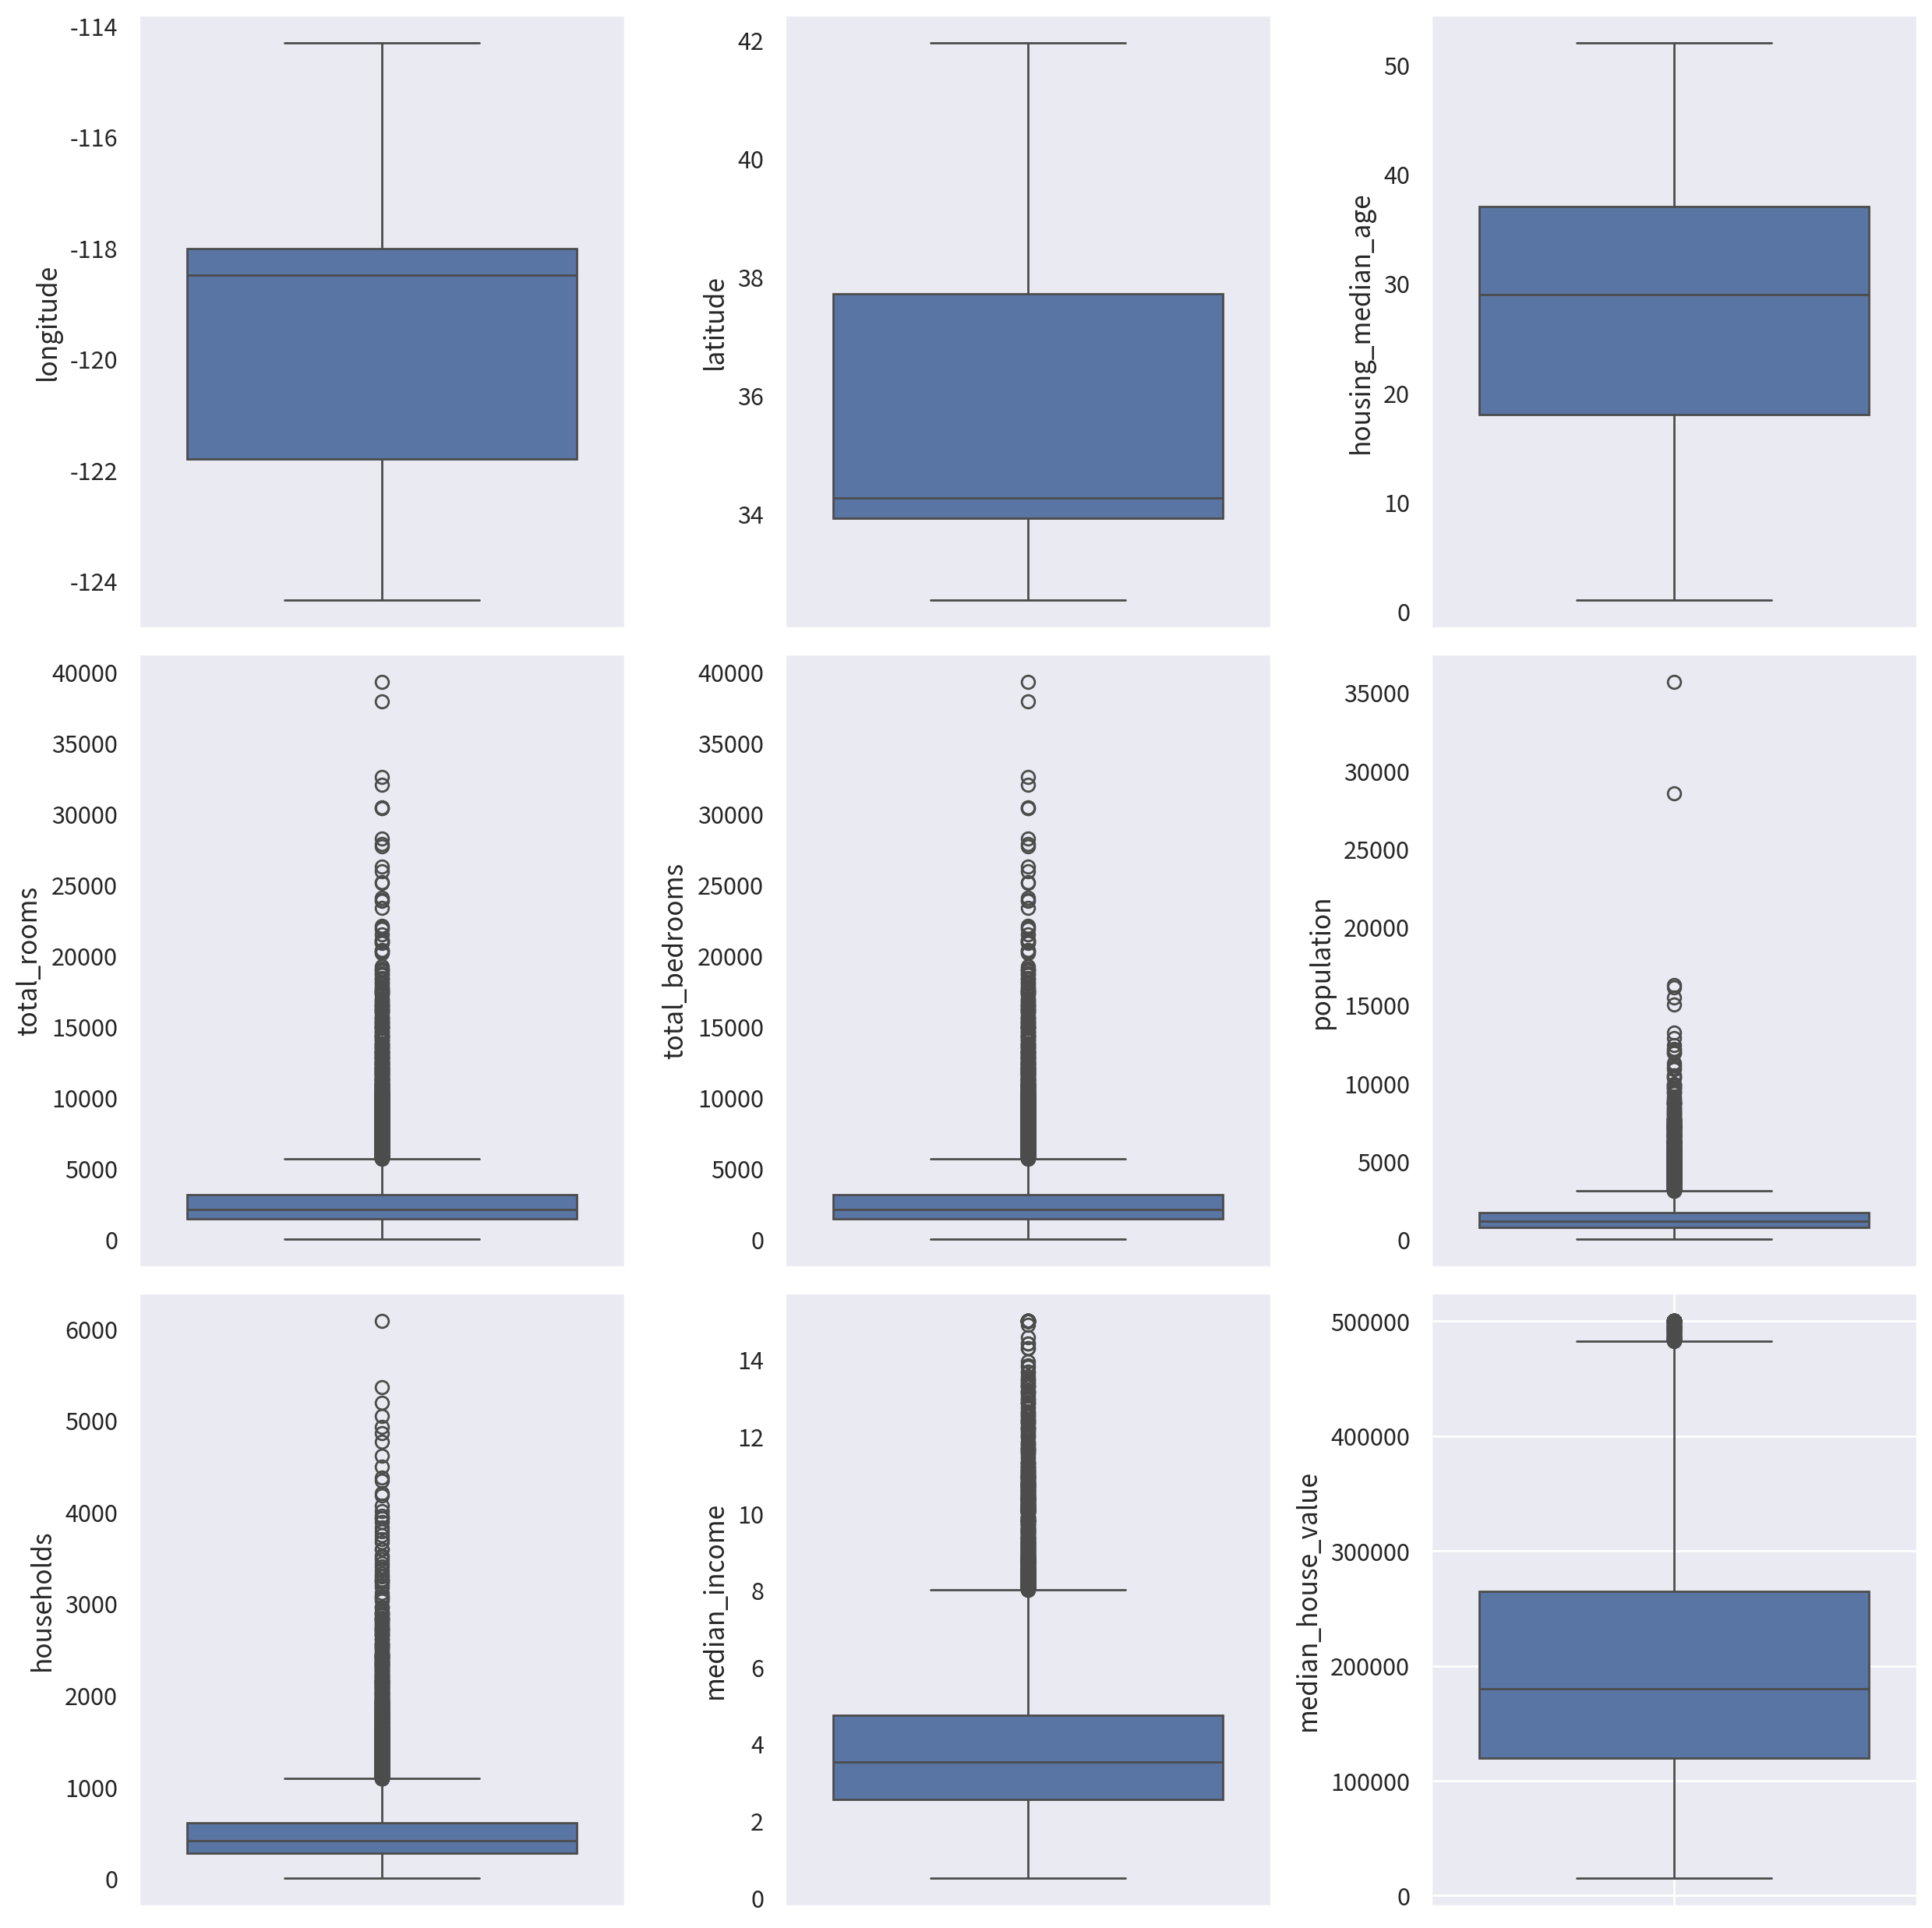

In [8]:
# 이상치를 알기 위해 박스플롯 시각화
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df['longitude'],orient='v',ax=ax[0][0])
sb.boxplot(data=df['latitude'],orient='v',ax=ax[0][1])
sb.boxplot(data=df['housing_median_age'],orient='v',ax=ax[0][2])
sb.boxplot(data=df['total_rooms'],orient='v',ax=ax[1][0])
sb.boxplot(data=df['total_bedrooms'],orient='v',ax=ax[1][1])
sb.boxplot(data=df['population'],orient='v',ax=ax[1][2])
sb.boxplot(data=df['households'],orient='v',ax=ax[2][0])
sb.boxplot(data=df['median_income'],orient='v',ax=ax[2][1])
sb.boxplot(data=df['median_house_value'],orient='v',ax=ax[2][2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 위도와 경도, 집의 나이 중위 수를 제외한 모든 컬럼에 이상치가 존재함
    - 이상치지만 틀린 데이터가 아니라 현실성에 가까운 데이터
    - 해당 데이터는 지역(블록 그룹)이라는 특성을 가진 데이터이기 때문에 규모가 클 수 있음.
        - 인구값이 5000이라면 방이 1만개인것은 이론상 가능한 수치라고 생각
    - 1940년 이전 주택이 52로 코딩되는 것은 상한선을 정해둔듯 함. median_house_value 같은 경우도 최댓값이 500,001로 되어있는 것을 보아 50만 달러가 넘어가는 데이터는 50.1만 달러로 상한선을 정해둠
        - 상한선이 정해져있기 때문에 50만 달러가 넘는 값을 예측하게 되면 성능이 떨어질 수 있음.
        - 상한선을 넘는 값을 예측하기 위해서는 추가적인 데이터가 필요함

In [9]:
#- 3. 특정 변수의 데이터 확인 및 영향 검토(housing_median_age의 값이 52인 값들)
# 상한선에 해당하는 데이터의 개수를 파악하기
print(df['median_house_value'].count())
print(df[df['median_house_value'] > 500000]['median_house_value'].count())
print(f"상한선 초과 데이터 비율: {df[df['median_house_value'] > 500000]['median_house_value'].count() / df['median_house_value'].count() * 100:.2f}%")

print(df['housing_median_age'].count())
print(df[df['housing_median_age'] == 52]['housing_median_age'].count())
print(f"상한선 초과 데이터 비율: {df[df['housing_median_age'] == 52]['housing_median_age'].count() / df['housing_median_age'].count() * 100:.2f}%")

20640
965
상한선 초과 데이터 비율: 4.68%
20640
1273
상한선 초과 데이터 비율: 6.17%


- median_house_value 와 housing_median_age 값의 상한선처럼 걸려있는 값들이 분석에 영향을 줄 수 있다고 판단 -> 소득이 올라가도 집 값은 안올라간다고 착각할 수 있고, 실제로 50만 달러가 아닌 집임에도 50만 달러를 학습시키는 것과 같은 효과
    - 분석 목적인 캘리포니아의 주거 시장을 이해하기 위해 상한선 값을 제거한 데이터를 가지고 분석 진행

In [10]:
# 상한선 제거 데이터 프레임은 df_cleaned 로 저장
# 상한선 제거 하지 않은 데이터 프레임은 df 로 저장
# 추후 두 데이터를 가지고 비교 분석 진행
df_cleaned = df[(df['median_house_value'] <= 500000) & (df['housing_median_age'] < 52)]
print(f"상한선 제거 전 데이터셋 크기 : {df.shape}")
print(f"상한선 제거 후 데이터셋 크기 : {df_cleaned.shape}")
print(f"제거된 데이터 비율: {(df.shape[0] - df_cleaned.shape[0]) / df.shape[0] * 100:.2f}%")


상한선 제거 전 데이터셋 크기 : (20640, 10)
상한선 제거 후 데이터셋 크기 : (18572, 10)
제거된 데이터 비율: 10.02%


- 데이터의 10%에 해당하는 값을 지운 만큼 비교 분석을 필요할듯.
    - 고가의 주택 가격을 예측할 때는 상한선 제거로 학습한 모델이 성능이 더 좋을것이라 예상하고 전처리 진행
- 4. 전처리 전,후가 어떻게 달라졌는지 한눈에 비교하는 표나 요약

In [11]:
print("전처리 전 데이터셋 기술통계량 \n")
df.describe()

전처리 전 데이터셋 기술통계량 



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,2635.763081,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,2181.615252,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,2.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,1447.750000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,2127.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,3148.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,39320.000000,35682.000000,6082.000000,15.000100,500001.000000


In [12]:
print("전처리 후 데이터셋 기술통계량 \n")
df_cleaned.describe()

전처리 후 데이터셋 기술통계량 



,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000,18572.000000
mean,-119.484929,35.593231,26.983847,2668.840997,2668.840997,1470.392957,508.721355,3.693262,189607.608066
std,1.980865,2.147712,11.431815,2223.829793,2223.829793,1162.944307,389.567263,1.570045,95790.237279
min,-124.300000,32.540000,1.000000,2.000000,2.000000,3.000000,2.000000,0.499900,14999.000000
25%,-121.550000,33.920000,17.000000,1454.750000,1454.750000,811.000000,284.000000,2.537275,115400.000000
50%,-118.450000,34.240000,27.000000,2142.000000,2142.000000,1203.000000,416.000000,3.468350,171200.000000
75%,-117.970000,37.670000,36.000000,3184.000000,3184.000000,1781.000000,614.000000,4.616100,243225.000000
max,-114.310000,41.950000,51.000000,39320.000000,39320.000000,35682.000000,6082.000000,15.000100,500000.000000


- 총 데이터 건 수 20640 -> 18572 (약 10% 삭제)
- 결측치 = 0 (total_bedrooms의 결측치를 total_rooms와의 비율로 대체)
- 이상치 처리 = 상한선이라고 판단되는 값(500,001 | 52)들 삭제 진행
    - 일반적인 캘리포니아의 주거 시장을 알아보기 위해서 삭제

### 미션 2. 가격과 핵심 변수의 첫 인상
- 1. median_house_value, median_income, housing_median_age, total_rooms 분포를 히스토그램/KDE로 확인 및 객관적 사실 서술
- 2. 왜도/이상치가 회귀에 줄 수 있는 영향과 변환할 필요가 있는지 서술
- 3. 분포 비교는 동일 축 스케일로 제시하고, 평균/중앙값/꼬리의 차이를 문장으로 요약
- 4. 지역별(Latitude/Longitude) 편향이나 시계열 문제(1990년 데이터만)가 해석에 미치는 영향도 짧게 언급

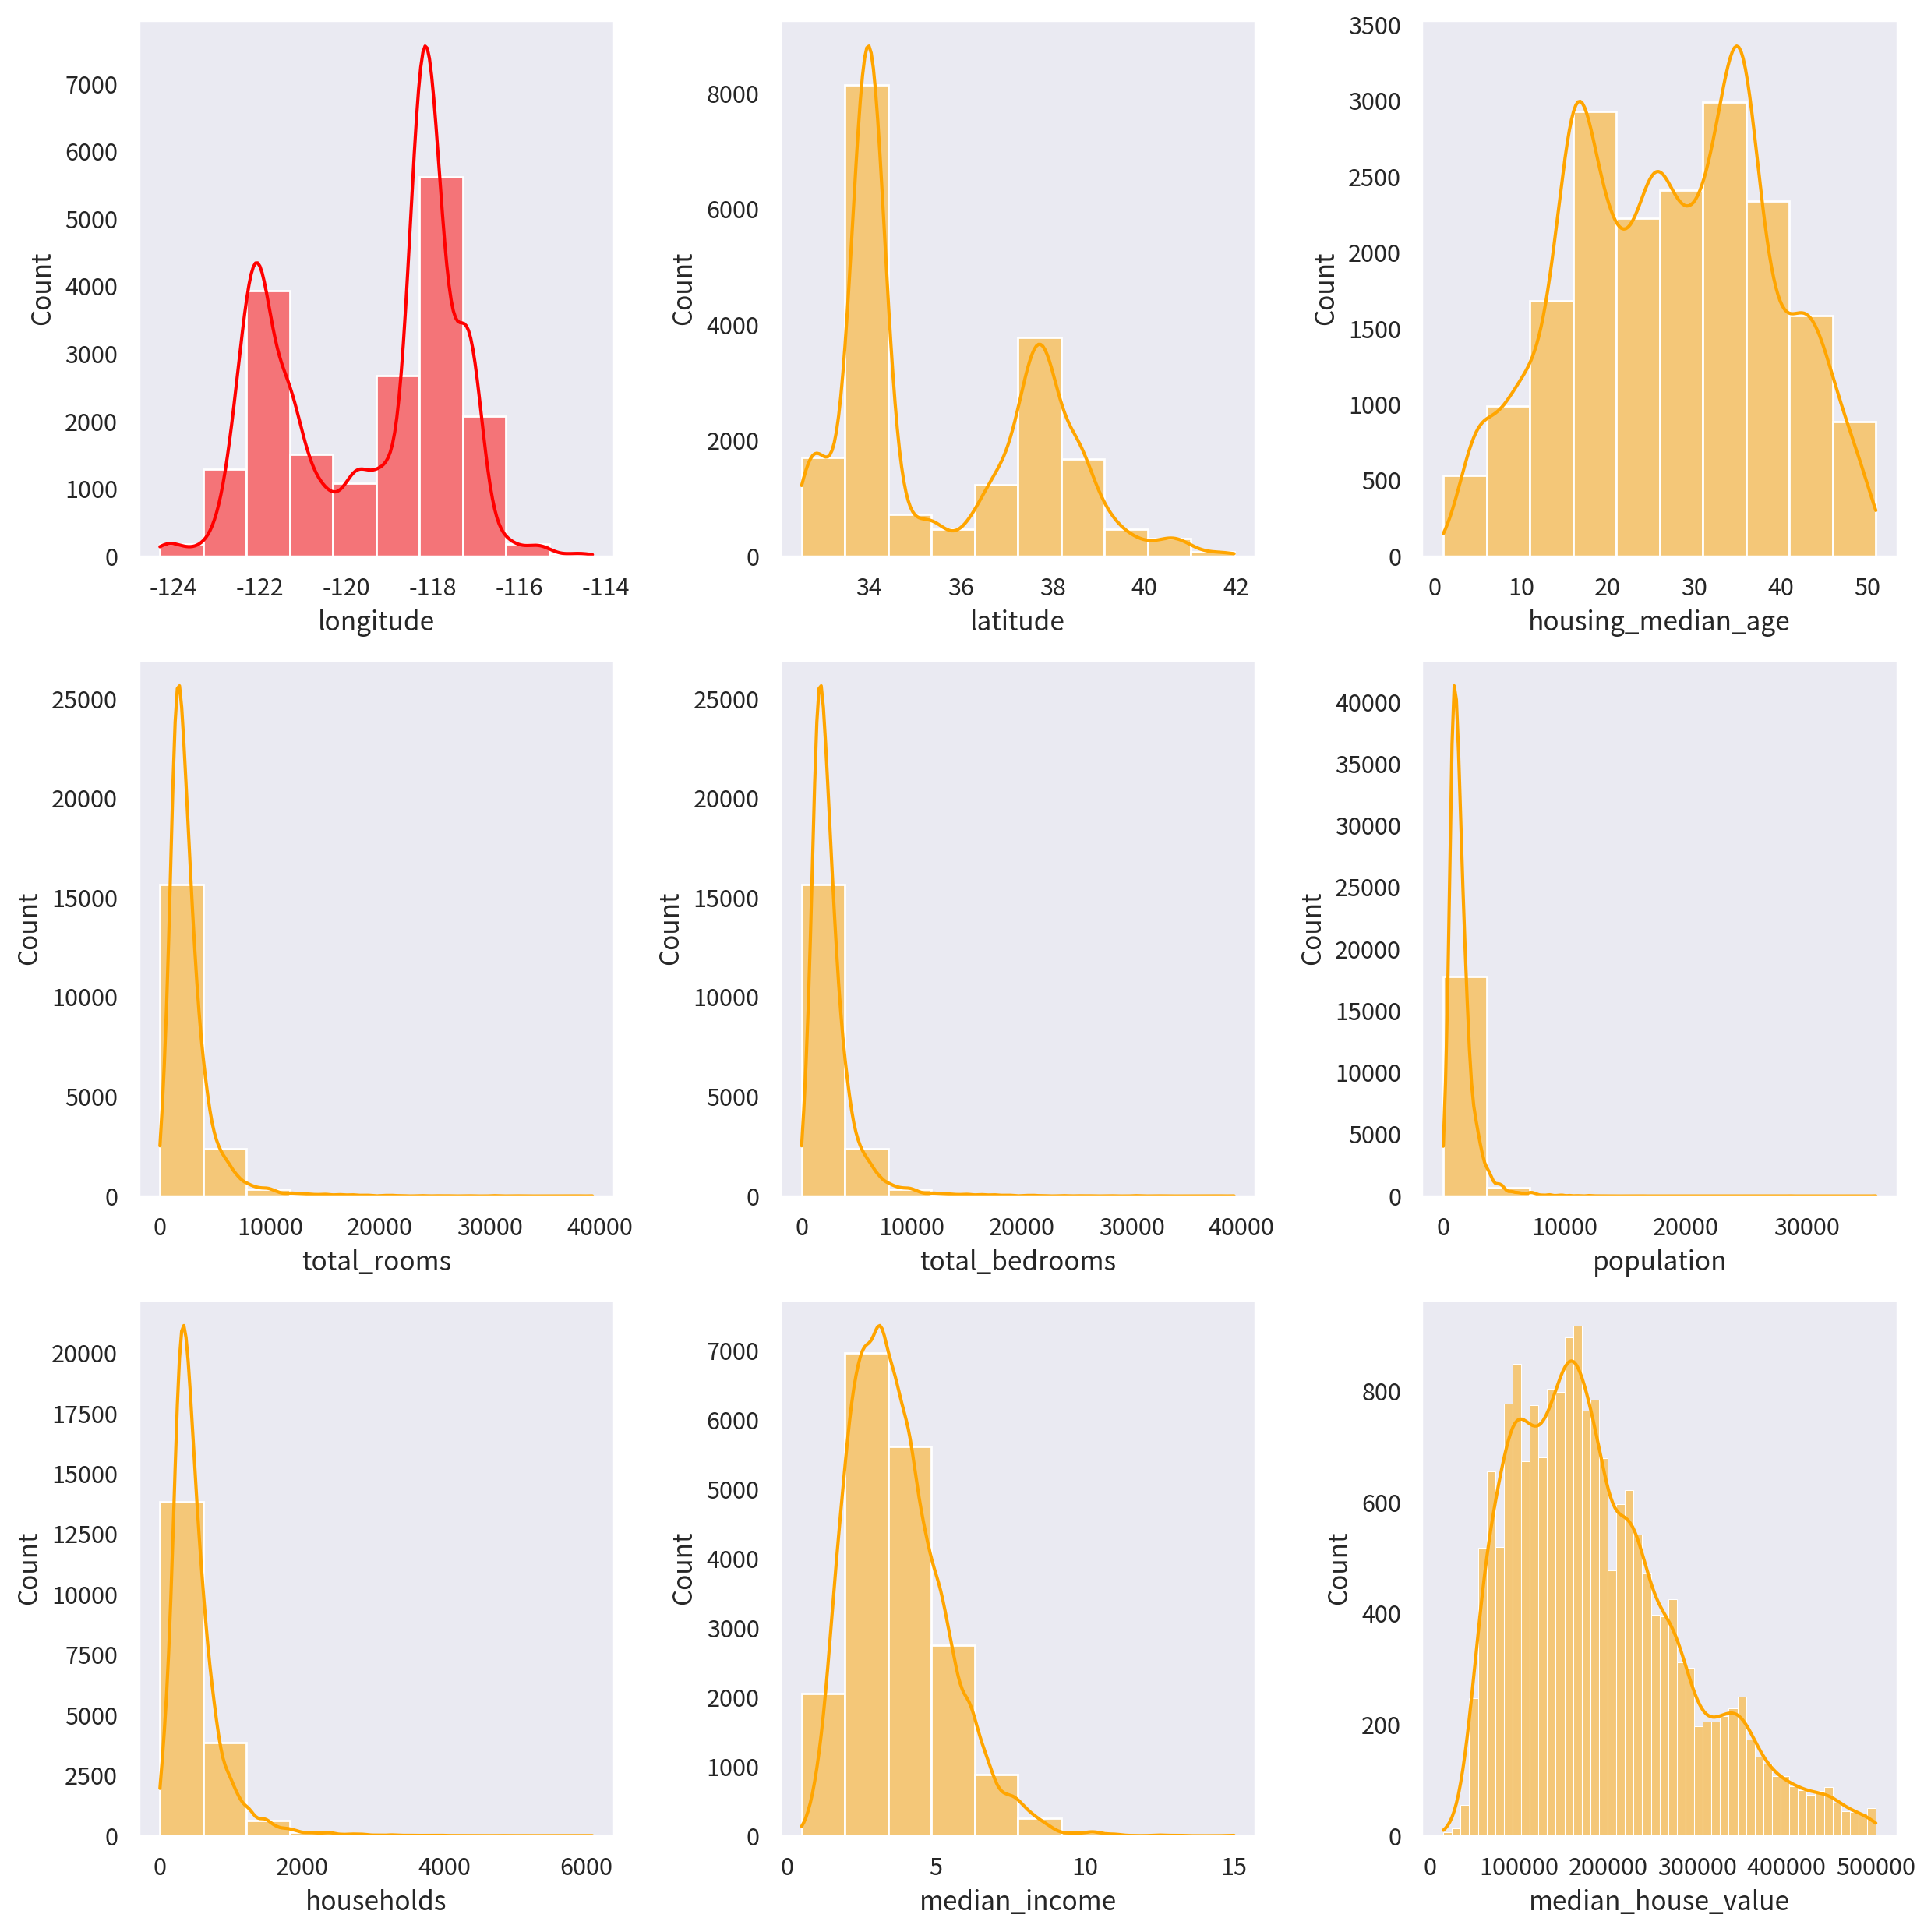

In [13]:
#1. median_house_value, median_income, housing_median_age, total_rooms 분포를 히스토그램/KDE로 확인 및 객관적 사실 서술
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 2500             #그래프 가로 크기
height_px = 2500             #그래프 세로 크기
rows = 3                    #도화지의 행 수
cols = 3                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.histplot(data=df_cleaned, x='longitude', bins=10, kde=True, color='red', ax=ax[0,0])
sb.histplot(data=df_cleaned, x='latitude', bins=10, kde=True, color='orange', ax=ax[0,1])
sb.histplot(data=df_cleaned, x='housing_median_age', bins=10, kde=True, color='orange', ax=ax[0,2])
sb.histplot(data=df_cleaned, x='total_rooms', bins=10, kde=True, color='orange', ax=ax[1,0])
sb.histplot(data=df_cleaned, x='total_bedrooms', bins=10, kde=True, color='orange', ax=ax[1,1])
sb.histplot(data=df_cleaned, x='population', bins=10, kde=True, color='orange',ax=ax[1,2])
sb.histplot(data=df_cleaned, x='households', bins=10, kde=True, color='orange',ax=ax[2,0])
sb.histplot(data=df_cleaned, x='median_income', bins=10, kde=True, color='orange',ax=ax[2,1])
sb.histplot(data=df_cleaned, x='median_house_value', bins=50, kde=True, color='orange',ax=ax[2,2])

# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용


# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 객관적 사실 서술
    - housing_median_age의 경우 상한선 값을 삭제하면서 비교적 고루게 분포해있는 모습을 알 수 있음
    - total_rooms, total_bedrooms, population,households의 경우 우편향이 매우 심함, 비율로 변환하기 위해 로그 변환 적용이 필요해보임
        - 왼쪽을 기준으로 최빈값-중앙값-평균순으로 나타나며 오른쪽으로 꼬리가 나있음
    - median_income의 경우 대부분의 데이터가 2~6 구간에 집중되어 있고, 우편향이 존재함
        - 소득의 불균형이 존재한다고 볼 수 있음
        - 우편향을 해소하기 위해 로그 변환 고려
        - 왼쪽을 기준으로 최빈값-중앙값-평균순으로 나타나며 오른쪽으로 꼬리가 나있음
    - median_house_value의 경우 상한선 값을 삭제하였지만 우편향을 보임
        - 로그 변환 고려
        - 왼쪽을 기준으로 최빈값-중앙값-평균순으로 나타나며 오른쪽으로 꼬리가 나있음
            - 명목형 변수 처리할 때 ISLAND 값이 5개 밖에 없는데 다 고소득 가구라서 빼고 진행해보기(일반적인 캘리포니아의 주택 시장 데이터라는 것의 일관성을 갖기 위해)
- 4. 지역별(Latitude/Longitude) 편향이나 시계열 문제(1990년 데이터만)가 해석에 미치는 영향도 짧게 언급
    - 데이터를 산점도로 찍어보면 알 수 있듯이 LA와 샌프란시스코 등 대도시권에 밀집되어있음
        - 모델이 대도시의 가격 결정을 진행할때는 매우 잘할 수 있지만, 외곽 지역, 데이터가 모자란 지역은 제대로 반영하지 못할 수 있음
    - 1990년 인구조사 당시의 데이터임
        - 현재의 가격 예측이 아니란 것을 다시 한번 명심하고 해당 프로젝트는 주택 가격을 결정하는 변수 간의 관계를 이해하는 지표로써 활용해야함.
    

### 미션 3. 로그/비선형 변환을 고민해보자.
- 1. 주요변수에 로그 변환을 적용해 전 후 분포를 나란히 비교
- 2. 변환이 해석과 모델 적합에 주는 장단점, 해석이 어떻게 달라지는지 예상
- 3. 이 변환이 없으면 어떤 함정에 빠질까?를 한 줄로 정리
- 4. 선택 기준을 명시 : 왜 이 변수에 log 변환을 적용하였는지를 데이터 분포 근거로 설명

In [14]:
df_cleaned_skewness = df_cleaned.drop(columns=['ocean_proximity'])
df_cleaned_skewness = df_cleaned_skewness.skew().sort_values(ascending=False)
print("전처리 후 왜도:\n", df_cleaned_skewness)
df_cleaned_log = df_cleaned.copy()
df_cleaned_log['total_rooms'] = np.log1p(df_cleaned_log['total_rooms'])
df_cleaned_log['total_bedrooms'] = np.log1p(df_cleaned_log['total_bedrooms'])
df_cleaned_log['population'] = np.log1p(df_cleaned_log['population'])
df_cleaned_log['households'] = np.log1p(df_cleaned_log['households'])
df_cleaned_log['median_income'] = np.log1p(df_cleaned_log['median_income'])
df_cleaned_log['median_house_value'] = np.log1p(df_cleaned_log['median_house_value'])
df2_log_skewness = df_cleaned_log.drop(columns=['ocean_proximity'])
df2_log_skewness = df2_log_skewness.skew().sort_values(ascending=False)
print("로그 변환 후 왜도:\n", df2_log_skewness)

전처리 후 왜도:
 population            4.931076
total_rooms           4.172955
total_bedrooms        4.172955
households            3.379298
median_income         0.890405
median_house_value    0.833960
latitude              0.519916
housing_median_age   -0.057075
longitude            -0.343758
dtype: float64
로그 변환 후 왜도:
 latitude              0.519916
median_income        -0.035021
housing_median_age   -0.057075
median_house_value   -0.280290
longitude            -0.343758
total_bedrooms       -0.964589
total_rooms          -0.964589
households           -0.974436
population           -1.006869
dtype: float64


- 로그 변환을 적용한 변수
    - total_rooms, total_bedrooms, population, households, median_income, median_house_value
    - 이유 : 그래프에서도 확인할 수 있듯이 왜도가 존재한다고 판단하여 로그 변환 적용 진행
- 로그 변환을 적용하지 않은 변수
    - longitude, latitude, housing_median_age
        - longitude, latitude: 경도와 위도 같은 경우 실제 좌표값을 의미하는 데이터로 로그 변환(비율 변환)이 의미가 없기 때문이고, 로그 변환을 진행하는 것보단 주 도심지와의 거리 계산 변수를 만들어 분석을 진행하는 것도 좋아보임 (추후 진행, 현 분석에는 사용하지 않음)
        - housing_median_age : 그래프 상 왜도가 심하지 않아보이기 때문에 적용하지 않음.
- 로그 변환 적용 후 왜도 개선
    - 왜도 수치가 4를 넘어간 population, total_rooms, total_bedrooms 변수들은 1,0.96으로 개선되었으며 3이 넘어갔던 households 또한 0.97로 개선되었음.
    - 모델이 이상치에 덜 민감하게 반응할 것임
- 로그 변환을 하지 않으면 모델이 구역의 규모가 큰 지역에 묶여 모델의 기울기가 망가짐
    - 일반적인 집값의 예측이 불가할 수준으로 만들어 질 것.

### 미션 4. 지리적 위치는 정말 중요할까?
- 1. 위도(Latitude)와 경도(Longitude)를 활용한 지리적 시각화 수행
- 2. 산점도(경도 X 위도, 점의 색상 = median_house_value)를 그려 주택 가격의 지리적 불평등 관찰
- 3. 어느 지역이 비싼가?, 가격 차이가 얼마나 뚜렷한가? 를 데이터 기반으로 설명
- 4. 위도/경도가 개별 변수보다 지역 표상(Proxy,대리자)이라는 점을 인식하고, 이것이 회귀에 주는 의미를 논의

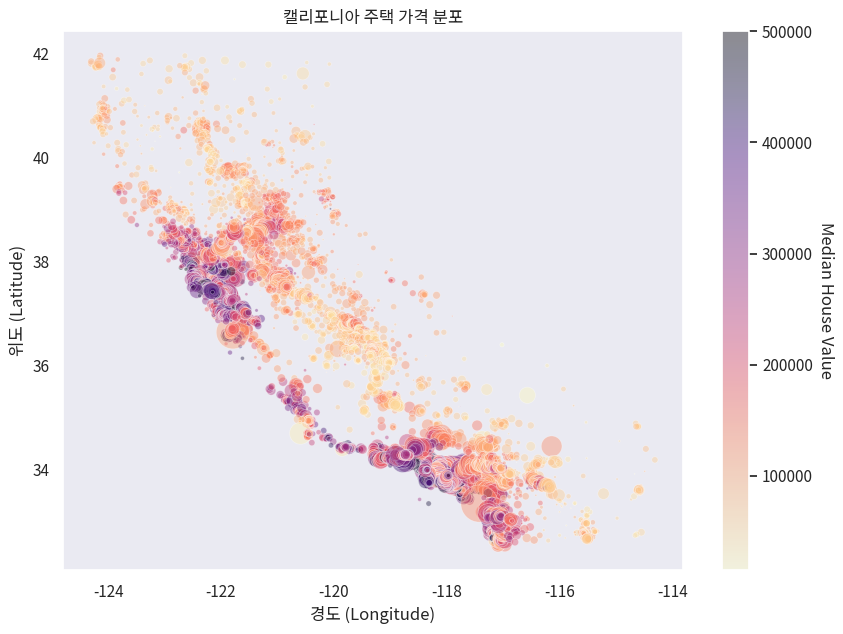

In [15]:
# 1. 위도(Latitude)와 경도(Longitude)를 활용한 지리적 시각화 수행
# 2. 산점도(경도 X 위도, 점의 색상 = median_house_value)를 그려 주택 가격의 지리적 불평등 관찰
# df_cleaned를 사용하여 색이 주택 가격, 크기가 인구 수에 비례하도록 산점도 작성
# df_cleaned_log는 로그 변환이 되어있기 때문에 산점도에서는 df_cleaned를 사용
# df_cleaned_log는 이후 분석에서 사용될 데이터 프레임
plt.figure(figsize=(10, 7))

scatter = plt.scatter(data=df_cleaned, x='longitude', y='latitude',
                      alpha=0.4, 
                      s=df_cleaned['population']/50,   
                      c=df_cleaned['median_house_value'], 
                      cmap='magma_r',edgecolors='w', linewidth=0.5)

cbar = plt.colorbar(scatter)
cbar.set_label('Median House Value', rotation=270, labelpad=15)

plt.xlabel('경도 (Longitude)')
plt.ylabel('위도 (Latitude)')
plt.title('캘리포니아 주택 가격 분포')
plt.show()

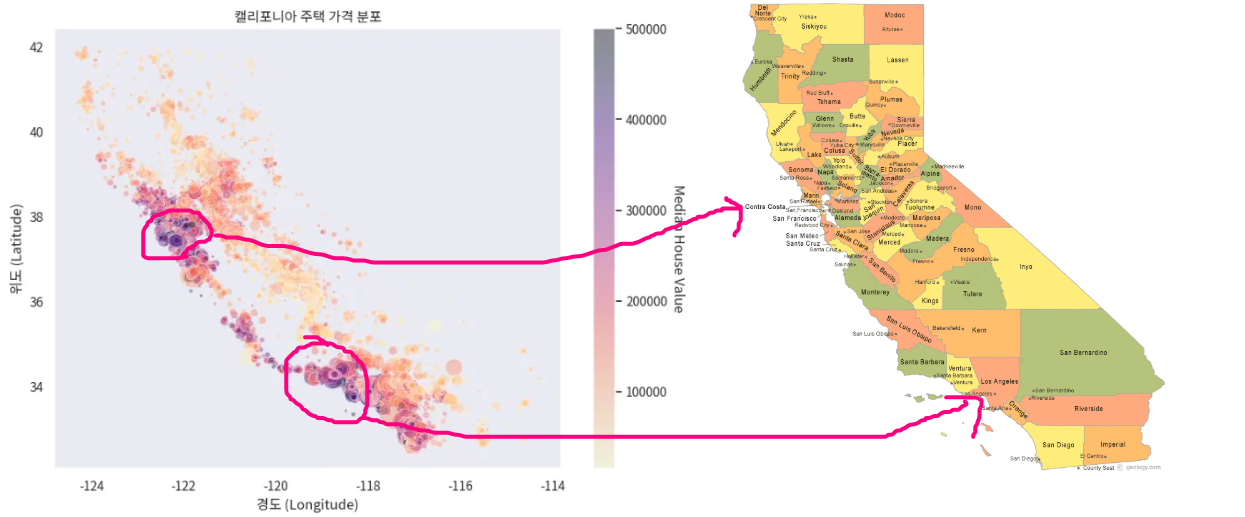


- 3. 어느 지역이 비싼가?, 가격 차이가 얼마나 뚜렷한가? 를 데이터 기반으로 설명
    - 색이 보라색으로 진하면서 원이 큰 곳 = 사람이 많고 집 값이 비싼 구역
    - 지도와 비교해 보았을 때 샌프란시스코와 로스앤젤레스에 해당
    - 주 도심지가 인구도 많고 집 값이 높게 형성되어 있는 것을 알 수 있음.
- 4. 위도/경도가 개별 변수보다 지역 표상(Proxy,대리자)이라는 점을 인식하고, 이것이 회귀에 주는 의미를 논의
    - 위도와 경도가 개별 변수보다 지역 표상이다 = 위도와 경도 자체의 데이터가 숫자 데이터가 아닌, 나타내는 지역의 이름(샌프란시스코, 로스앤젤리스)을 나타낸다는 것을 알아야 한다.
- 회귀 분석을 진행할 때 유의해야하는 이유
    - 선형 회귀는 숫자가 커지면 가격도 그만큼 변한다라고 생각하는데, 위도가 높아진다고 가격이 높아지는 것이 아니기 때문에 우리는 위도와 경도 데이터를 지역적 특성으로 고려하고 진행해야함
    - 정리하면, 위도와 경도는 입지를 나타내는 데이터이며 해당 변수는 단순 선형 관계를 갖지 않는다는 것을 알고 이런 정보들을 통해 파생변수를 이끌어 낼 줄 알아야 함.
        - ex) 인구가 많고 집값이 비싼(샌프란시스코, 로스앤젤리스)구역 과의 거리는 집값에 영향이 있는지? (주도심지와의 거리) 혹은 해안가 주변이 집값에 영향이 있는지?(ocean_proximity가 존재하긴함)와 같은 실질적인 가격 결정 요인을 모델이 학습할 수 있음
    - 위도와 경도 데이터를 사용하기 위해 주도심지와의 거리를 계산한 파생 변수를 만들어 선형회귀에 사용할 것.
        - 주도심지와의 거리가 추가된 데이터프레임 df_cleaned_dist 생성

In [16]:
# df_cleaned_dist는 위도와 경도를 기준으로 주 도심지와의 거리를 계산한 파생 변수가 들어가있는 데이터 프레임
df_cleaned_dist = df_cleaned.copy()
# 1. 북부 중심지 (샌프란시스코 권역: 위도 36도 이상에서 가장 비싼 곳)
sf_idx = df_cleaned[df_cleaned['latitude'] > 36]['median_house_value'].idxmax()
sf_center = (df_cleaned.loc[sf_idx, 'latitude'], df_cleaned.loc[sf_idx, 'longitude'])

# 2. 남부 중심지 (로스앤젤레스 권역: 위도 36도 이하에서 가장 비싼 곳)
la_idx = df_cleaned[df_cleaned['latitude'] <= 36]['median_house_value'].idxmax()
la_center = (df_cleaned.loc[la_idx, 'latitude'], df_cleaned.loc[la_idx, 'longitude'])

print(f"경제적 중심지 - SF: {sf_center}, LA: {la_center}")


경제적 중심지 - SF: (np.float64(36.58), np.float64(-121.94)), LA: (np.float64(34.06), np.float64(-118.38))


In [17]:
# 하버사인 공식 함수 (위경도를 km로 변환)
def haversine_distance(lat1, lon1, lat2, lon2):
    # 지구 반지름 (km)
    r = 6371 
    
    # 라디안 변환
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    
    # 공식 적용
    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    
    return r * c

# 1. SF와 LA로부터의 거리 계산 (km 단위)
df_cleaned_dist['dist_sf_km'] = haversine_distance(df_cleaned_dist['latitude'], df_cleaned_dist['longitude'], 
                                                  sf_center[0], sf_center[1])

df_cleaned_dist['dist_la_km'] = haversine_distance(df_cleaned_dist['latitude'], df_cleaned_dist['longitude'], 
                                                  la_center[0], la_center[1])

# 2. 둘 중 더 가까운 도심까지의 거리 선택 및 소수점 4자리 반올림
df_cleaned_dist['nearest_city_dist'] = df_cleaned_dist[['dist_sf_km', 'dist_la_km']].min(axis=1).round(4)

# 결과 확인
df_cleaned_dist.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,dist_sf_km,dist_la_km,nearest_city_dist
0,-122.23,37.88,41,880,880,322,126,8.3252,452600,NEAR BAY,146.815600,548.030710,146.8156
1,-122.22,37.86,21,7099,7099,2401,1138,8.3014,358500,NEAR BAY,144.472535,545.768059,144.4725
8,-122.26,37.84,42,2555,2555,1206,595,2.0804,226700,NEAR BAY,142.942550,546.368884,142.9425
15,-122.26,37.85,50,1120,1120,697,264,2.1250,140000,NEAR BAY,144.032225,547.210086,144.0322
18,-122.26,37.84,50,2239,2239,990,419,1.9911,158700,NEAR BAY,142.942550,546.368884,142.9425


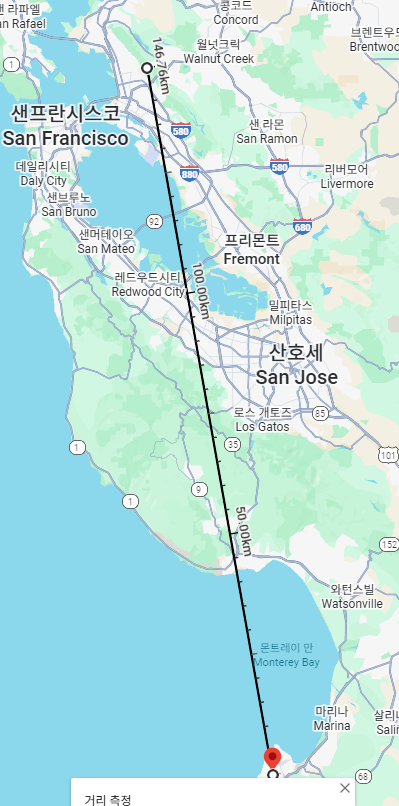
- 실제 거리 측정 해보니 146.81(지도상 146.76km)로 일치하는 것을 확인함

In [18]:
#선형회귀에 사용할 변수만 두기 위해 계산에 쓰인 파생변수 제거
df_final_dist = df_cleaned_dist.drop(columns=['latitude','longitude','dist_sf_km', 'dist_la_km'])
# nearest_city_dist는 샌프란시스코와 로스앤젤레스 중 더 가까운 도심까지의 거리(km)를 나타낸 변수
df_final_dist.head()

,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,nearest_city_dist
0,41,880,880,322,126,8.3252,452600,NEAR BAY,146.8156
1,21,7099,7099,2401,1138,8.3014,358500,NEAR BAY,144.4725
8,42,2555,2555,1206,595,2.0804,226700,NEAR BAY,142.9425
15,50,1120,1120,697,264,2.1250,140000,NEAR BAY,144.0322
18,50,2239,2239,990,419,1.9911,158700,NEAR BAY,142.9425


- 중심지와의 거리(샌프란시스코와 로스엔젤레스에 해당하는 좌표 중 집 값이 가장 높은 가격을 갖는 좌표와의 거리) 변수를 추가함으로써 위도와 경도 변수 삭제
    - 다중공선성 문제를 일으킬 확률이 높기 때문에 선행 삭제 진행
- ocean_proximity 변수 더미 변수화 진행

In [19]:
#ocean_proximity의 데이터 종류 알아보기
print(df_final_dist['ocean_proximity'].unique())

['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [20]:
#ocean_proximity 더미 변수화, ISLAND에 해당하는 데이터가 2건인데 고가의 데이터만 들어있어 제외하고 진행
df_final = df_cleaned_log.merge(df_final_dist[['nearest_city_dist',]], left_index=True, right_index=True)
df_fianl= df_final[df_final['ocean_proximity'] != 'ISLAND'].copy()
# df_final.head()
# df_fianl.describe() 2건 삭제된 것을 확인함
# 더미변수화
df_final = pd.get_dummies(df_fianl, columns=['ocean_proximity'], drop_first=True, dtype=int)
df_final=df_final.drop(columns=['longitude','latitude'])
df_final.head()
# 최종 데이터 프레임 로그 버전에 거리 데이터 추가



,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,nearest_city_dist,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,41,6.781058,6.781058,5.777652,4.844187,2.232720,13.022766,146.8156,0,1,0
1,21,8.867850,8.867850,7.784057,7.037906,2.230165,12.789687,144.4725,0,1,0
8,42,7.846199,7.846199,7.095893,6.390241,1.125059,12.331387,142.9425,0,1,0
15,50,7.021976,7.021976,6.548219,5.579730,1.139434,11.849405,144.0322,0,1,0
18,50,7.714231,7.714231,6.898715,6.040255,1.095641,11.974777,142.9425,0,1,0


- 최종 데이터 프레임 (*는 로그가 적용되어있는 변수, **는 분석을 위해 생성된 파생 변수)
    - housing_median_age,*total_rooms, *total_bedrooms, *population
    - *households, *median_income, *median_house_value, **nearest_city_dist
    - ocean_proximity_INLAND, ocean_proximity_NEAR BAY, ocean_proximity_NEAR OCEAN
- 11개


### 미션 5. 소득은 정말로 집값을 결정할까?
- 1. median_income(중위 가구 소득)에 따라 median_house_value가 다른지 시각화하고, 선형성과 강도를 평가함
- 2. 산점도와 함께 회귀선을 그려 관계의 형태를 관찰
- 3. 상관계수(Pearson)를 계산하고 정말로 소득이 집값의 주 결정 요인인가?를 비판적으로 생각
- 4. 소득 수준에 따른 주택가격 불평등 문제를 해석 관점에서 논의

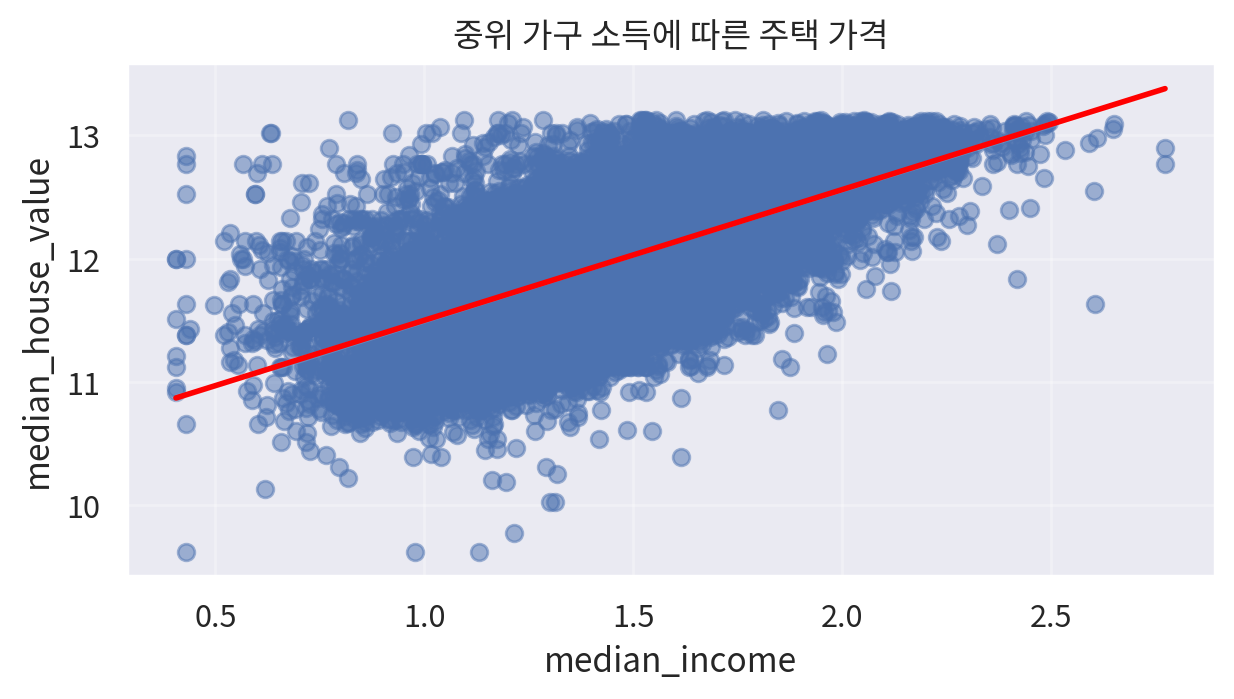

In [21]:
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.regplot(data=df_final, x='median_income', y='median_house_value',
           scatter_kws={'alpha':0.5},
           line_kws={'color':'red', 'linewidth':2})
plt.title('중위 가구 소득에 따른 주택 가격')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

1. median_income(중위 가구 소득)에 따라 median_house_value가 다른지 시각화하고, 선형성과 강도를 평가함
2. 산점도와 함께 회귀선을 그려 관계의 형태를 관찰
- 회귀선이 우상향을 하고 있음
    - 이는 소득이 높을수록 집값도 비싸진다라는 사실을 알 수 있음
    - 데이터 점들이 회귀선 주변에 몰려있어 변수의 설명력이 올라감을 알려줌
    
- 분포 특징
    - 소득이 적은 구간(0.5~1.0)에서 주택 가격의 분산이 크다
        - 같은 소득 수준에서도 주택 가격 차이가 크다는 것을 의미함
    - 소득이 높아질수록 분산이 줄어듦
        - 이는 상한선 데이터들을 제거해서 나타나는 현상으로 추정
- median_income으로는 모든 변동을 설명하기엔 분포가 다양함

In [22]:
x = df_final['median_income']
y = df_final['median_house_value']

X = sm.add_constant(x)
model = sm.OLS(y, X).fit()
reset = linear_reset(model, power=2, use_f=True)

#선형성 적합 여부(True=적합, False=부적합)
linearity_ok = reset.pvalue > 0.05
print(f"Ramsey RESET Test : {'선형성 적합' if linearity_ok else '선형성 위반'} (p-value: {reset.pvalue:.4f})")


Ramsey RESET Test : 선형성 위반 (p-value: 0.0000)


- 3. 상관계수(Pearson)를 계산하고 정말로 소득이 집값의 주 결정 요인인가?를 비판적으로 생각
- 4. 소득 수준에 따른 주택가격 불평등 문제를 해석 관점에서 논의

In [23]:
import pandas as pd
data = df_final[['median_income','median_house_value']]
results = {}

for col in data.columns:
    temp = data[col].dropna()

    #왜도 계산
    skew_original = temp.skew()

    # Z-scoore 기반 이상치 탐지 (|z| > 3)
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    #로그 변환 후 왜도 계산(음수 대비 + 1)
    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    #로그 변환 필요 여부 판단
    need_log = (abs(skew_original) > 1) and (abs(skew_log) < abs(skew_original))

    results[col] = {
        'original_skew': skew_original,
        'log_skew': skew_log,
        'outliers(|z| > 3)': outlier_count,
        'log_recommend': need_log
    }

results_df = pd.DataFrame(results).T
display(results_df)

# 이상치 점검 결과
outlier_flag = len(results_df[results_df['outliers(|z| > 3)'] >0])>0
if outlier_flag:
    print("이상치가 발견되어 스피어만 상관계수 사용")
else:
    print("이상치가 발견되지 않아 피어슨 상관계수 사용")

,original_skew,log_skew,outliers(|z| > 3),log_recommend
median_income,-0.03522,-0.330724,33,False
median_house_value,-0.280329,-0.595147,18,False


이상치가 발견되어 스피어만 상관계수 사용


In [24]:
spearman_r, spearman_p = spearmanr(df_final['median_income'], df_final['median_house_value'])
"staticstic: {0:.3f}, p-value: {1:.3f}, {2}가설 채택".format(spearman_r, spearman_p, "대립" if spearman_p <= 0.05 else "귀무")

'staticstic: 0.663, p-value: 0.000, 대립가설 채택'

- 귀무가설 : 소득은 집값의 주결정요인이 아니다.
- 대립가설 : 소득은 집값의 주결정요인이다.
    - 대립가설 채택
- 소득 수준에 따른 주택가격 불평등 문제를 해석 관점에서 논의하세요
    - 소득이 높지 않은 가구의 주택 가격이 비싼 이유에 대해 알아볼 필요가 있음.
    - 소득이 오를수록 주택 가격도 비싸지는 것으로 보아 주 요인이라고는 볼 수 있음.
    - 저소득 구간에서 고가의 주택이 몇몇 보이지만 대부분 저가의 주택으로 구성됨
        - 이는 선택할 수 있는 주택 가격의 범위가 제한적이라고 볼 수 있음.
    - 고소득 구간으로 갈 수록 주거 선택지가 많아짐
        - 양극화가 일어남
    - 같은 소득이지만 주택 가격의 차이가 많이 남
        - 소득 수준은 주택 가격의 주된 요인이라고 할 수 있지만, 다른 요인의 유무가 주택 가격 형성에 기여를 하고 있다는 것을 알 수 있음.

### 미션 6. 주택 특성은 소수일까, 다수일까?
- 1. total_rooms, total_bedrooms, households, median_house_age, population의 분포를 확인
- 2. 각 변수별로 생존자(정상) vs 이상치를 구분하고, 회귀에 미칠 영향을 평가
- 3. 일부 극단값(예: 매우 작은 방의 수, 매우 높은 인구밀도)이 전체 분석을 왜곡할 가능성을 검토

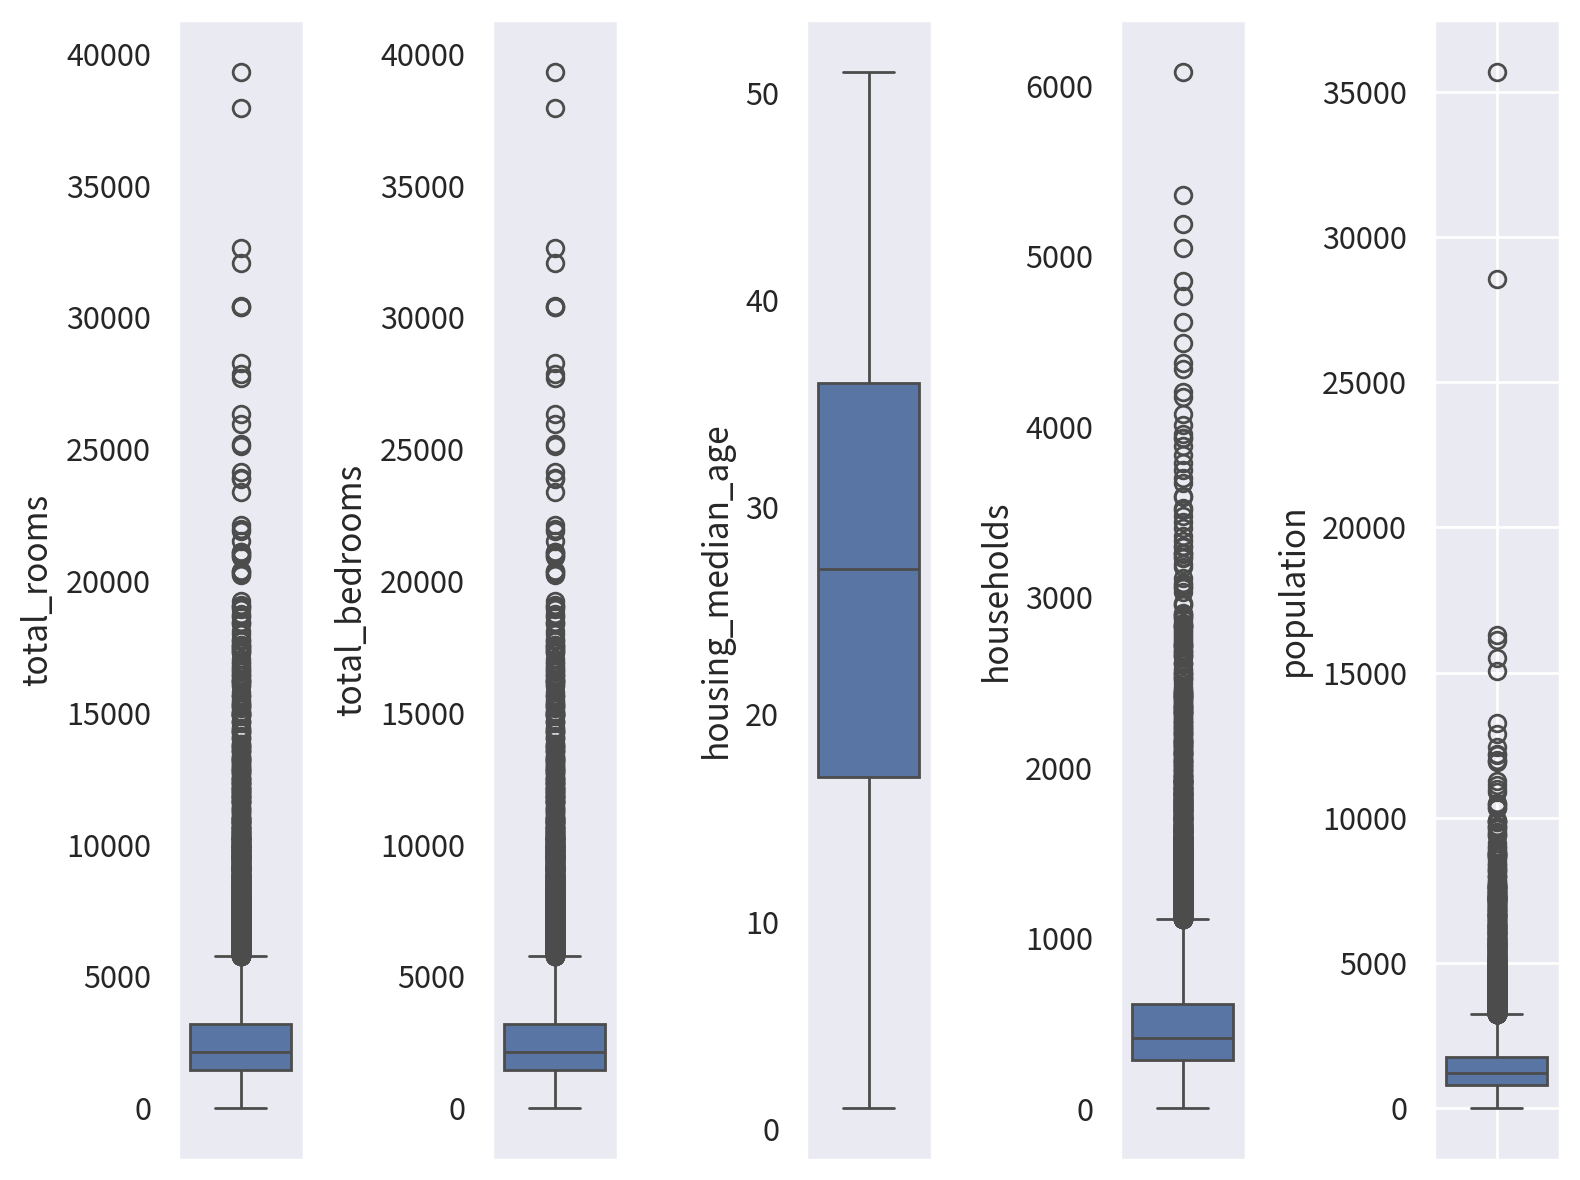

In [25]:
# 주요 변수의 이상치를 확인하기 위해서 최종 데이터 프레임(로그 적용)이 아닌 df_cleaned를 사용
# 1) 그래프 초기화 (캔버스(fig)와 도화지(ax) 준비하기)
width_px = 1600             #그래프 가로 크기
height_px = 1200             #그래프 세로 크기
rows = 1                    #도화지의 행 수
cols = 5                    #도화지의 열 수
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, figsize = figsize, dpi = my_dpi)

# 2) 그래프 그리기 -> seaborn 사용
sb.boxplot(data=df_cleaned['total_rooms'],orient='v',ax=ax[0])
sb.boxplot(data=df_cleaned['total_bedrooms'],orient='v',ax=ax[1])
sb.boxplot(data=df_cleaned['housing_median_age'],orient='v',ax=ax[2])
sb.boxplot(data=df_cleaned['households'],orient='v',ax=ax[3])
sb.boxplot(data=df_cleaned['population'],orient='v',ax=ax[4])
# 3) 그래프 꾸미기 -> 도화지(ax)에 직접 적용
plt.grid(True)

# 4) 출력
plt.tight_layout()                      #여백 제거
# plt.savefig("myplot.png", dpi=my_dpi)   #생략 가능
plt.show()                              #그래프 화면 출력
plt.close()                             #그래프 작업 종료

- 데이터의 분포가 극단적이라 로그 변환을 했었음
- total_rooms는 0~5682.5 | total_bedrooms : 0 ~ 1173.5
- population : 0 ~ 3124.5 | households : 0 ~ 1090.0

- housing_median_age : 0 ~ 65.5 

- 상식선으로 총 방 개수가 4만개면 가구수가 6000개 있는 지역이라 했을 때 6000개 모두 방이 7개 가량 있다는 뜻
    - kaggle 데이터 셋인 California housing의 AveRooms를 참고하면 평균 방 수가 7개 이상인 데이터 건수가 꽤 되는 것 같아서 현실성 있다고 판단.
    - 4~5개가 평균인 듯 하며, 안정범위인 5682.5는 저소득 구간의 주택에 방 개수로 측정 된 것.
    - 고가의 주택 방 개수가 많기 때문에 이상치가 많이 찍힘
    - 이는 빈부격차로 인한 데이터 분포의 비대칭성이 일어난 것.
    - 이상치로 여기지 않고 충분히 있을 수 있는 조건이라고 생각하고 별도의 전처리 X


In [26]:
# 데이터의 정상 범위 출력하기
data_columns = ['total_rooms', 'total_bedrooms', 'housing_median_age', 'households', 'population']
Q1 = df_cleaned[data_columns].quantile(0.25)
Q3 = df_cleaned[data_columns].quantile(0.75)
IQR = Q3 - Q1

for i in data_columns:
    # lower_bound가 음수가 될 수 있으므로 음수면 0으로 처리
    lower_bound = max(0, Q1[i] - 1.5 * IQR[i])  #max함수로 0과 비교했을 때 0이 더 크면 0이 나옴
    upper_bound = Q3[i] + 1.5 * IQR[i]
    print(f"{i}의 정상 범위: {lower_bound} ~ {upper_bound}")

total_rooms의 정상 범위: 0 ~ 5777.875
total_bedrooms의 정상 범위: 0 ~ 5777.875
housing_median_age의 정상 범위: 0 ~ 64.5
households의 정상 범위: 0 ~ 1109.0
population의 정상 범위: 0 ~ 3236.0


### 미션 7. 소득과 다른 특성은 독립적일까?
- 1. 주요 연속형 변수 간 상관행렬(median_income, housing_median_age, total_rooms, total_bedrooms, population, households,위도,경도)을 계산
- 2. 상관행렬을 히트맵으로 시각화하고, Variance Inflation Factor(VIF)로 다중공선성을 점검
- 3. 높은 상관이 보이는 변수 쌍(예: total_rooms vs total_bedrooms)에 대해, 이것이 모델 설계에 주는 함의를 논의
- 4. 공선성 완화 전략을 고민하세요 : 변수 제거, 결합지표 설계 등 "해석 우선" 관점에서 선택

In [27]:
skew_outlier={}
for col in df_final.columns:
    temp = df_final[col].dropna()
    skew_original = temp.skew()
    z_scores = zscore(temp)
    outlier_count = int(np.sum(np.abs(z_scores) > 3))

    data_log = np.log1p(temp - temp.min() + 1)
    skew_log = data_log.skew()

    skew_outlier[col]= {
        'original_skew': skew_original,
        # 'log_skew': skew_log,
        # df_final이 이미 로그 변환된 데이터 프레임이므로 log_skew는 불필요
        'outliers(|z| > 3)': outlier_count
    }
skew_outlier_df=DataFrame(skew_outlier).T
skew_outlier_df

,original_skew,outliers(|z| > 3)
housing_median_age,-0.057044,0.0
total_rooms,-0.964825,257.0
total_bedrooms,-0.964825,257.0
population,-1.007169,267.0
households,-0.974646,268.0
median_income,-0.035220,33.0
median_house_value,-0.280329,18.0
nearest_city_dist,1.245852,341.0
ocean_proximity_INLAND,0.667938,0.0
ocean_proximity_NEAR BAY,2.990698,1567.0


In [28]:
rows = []

for a, b in combinations(df_final.columns,2):
    x = df_final[a]
    y = df_final[b]

    # [1] 선형성 확인(Ramsey RESET)
    X = sm.add_constant(x)
    model = sm.OLS(y, X).fit()
    reset = linear_reset(model, power=2, use_f=True)
    linearity_ok = reset.pvalue>0.05

    # [2] 이상치 존재 여부(|z| > 3 기준)
    a_flag = skew_outlier_df.loc[a, 'outliers(|z| > 3)'] >0
    b_flag = skew_outlier_df.loc[b, 'outliers(|z| > 3)'] >0
    outlier_flag = a_flag or b_flag

    # [3] 상관계수 선택 및 계산
    if linearity_ok and not outlier_flag:
        chosen = 'pearson'
        corr, pval = pearsonr(x,y)
    else:
        chosen = 'spearman'
        corr,pval = spearmanr(x,y)

    # [4] 유의성 판단(p <= 0.05)
    significant = pval <= 0.05

    # [5] 상관 강도 계산
    abs_r = abs(corr)
    if abs_r >= 0.80:
        strength = 'Very strong'
    elif abs_r >= 0.60:
        strength = 'Strong'
    elif abs_r >= 0.40:
        strength = 'Medium'
    elif abs_r >= 0.20:
        strength = 'Weak'
    else:
        strength = 'Very weak'
    
    # [6] 행 추가
    rows.append({
        "var_a": a,
        "var_b": b,
        "linearity": linearity_ok,
        "outlier_flag": outlier_flag,
        "chosen": chosen,
        "corr": corr,
        "pval": pval,
        "significant": significant,
        "strength": strength
    })

summary_df = DataFrame(rows)
summary_df

,var_a,var_b,linearity,outlier_flag,chosen,corr,pval,significant,strength
0,housing_median_age,total_rooms,False,True,spearman,-0.372687,0.000000e+00,True,Weak
1,housing_median_age,total_bedrooms,False,True,spearman,-0.372687,0.000000e+00,True,Weak
2,housing_median_age,population,True,True,spearman,-0.258193,1.545273e-280,True,Weak
3,housing_median_age,households,True,True,spearman,-0.286500,0.000000e+00,True,Weak
4,housing_median_age,median_income,False,True,spearman,-0.185314,3.998341e-143,True,Very weak
5,housing_median_age,median_house_value,True,True,spearman,0.006280,3.921707e-01,False,Very weak
6,housing_median_age,nearest_city_dist,False,True,spearman,-0.305402,0.000000e+00,True,Weak
7,housing_median_age,ocean_proximity_INLAND,False,False,spearman,-0.222440,6.513417e-207,True,Weak
8,housing_median_age,ocean_proximity_NEAR BAY,False,True,spearman,0.140312,2.801517e-82,True,Very weak
9,housing_median_age,ocean_proximity_NEAR OCEAN,False,False,spearman,0.035953,9.555318e-07,True,Very weak


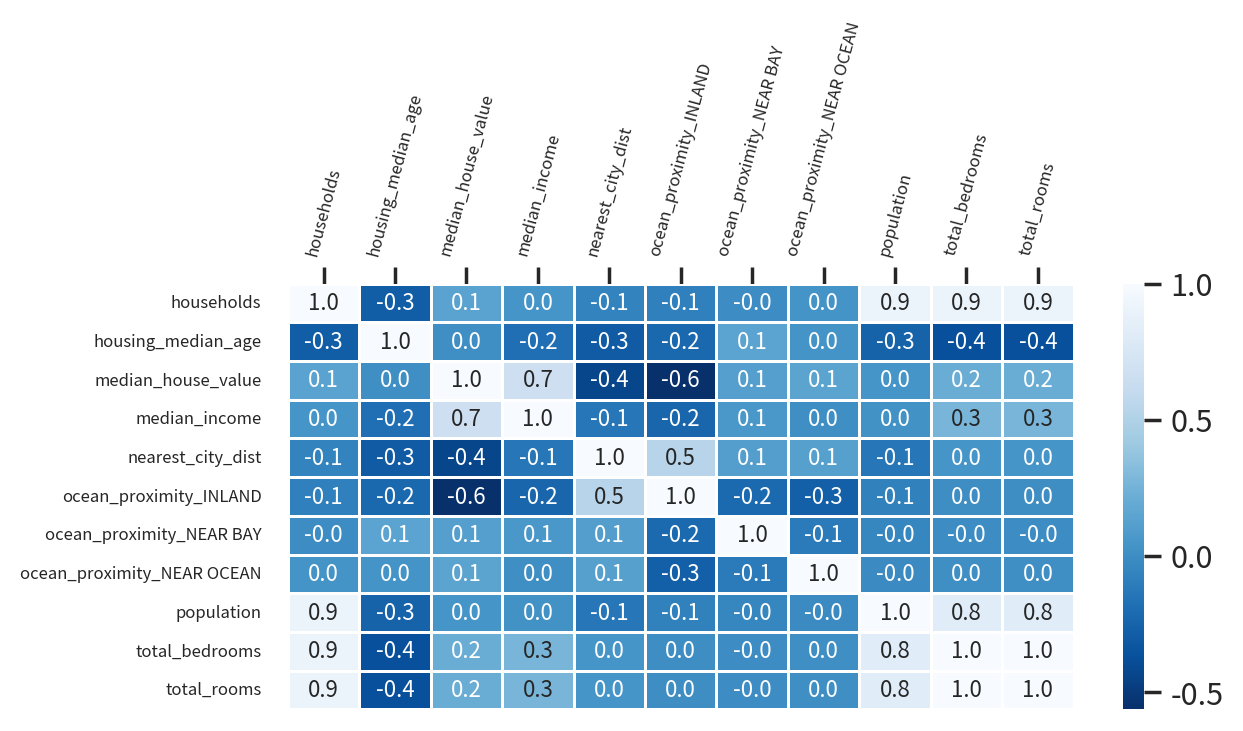

In [43]:
# 1) 등장하는 모든 변수 목록 추출
vars = sorted(set(summary_df['var_a']).union(summary_df['var_b']))

# 2) 빈 상관행렬 생성 (NaN으로 초기화)
corr_matrix = DataFrame(np.nan, index=vars, columns=vars)

# 3) summary_df 내용을 반영하여 대칭 행렬 채우기
for _, row in summary_df.iterrows():
    a, b, r = row['var_a'], row['var_b'], row['corr']
    corr_matrix.loc[a, b] = r
    corr_matrix.loc[b, a] = r # 대칭

# 4) 대각선 (diagonal)을 1로 설정
np.fill_diagonal(corr_matrix.values, 1)

# corr_matrix
width_px = 1280
height_px = 720
rows = 1
cols = 1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig,ax = plt.subplots(rows, cols, figsize=figsize, dpi=my_dpi)

sb.heatmap(data=corr_matrix, annot=True, fmt='0.1f', linewidth=0.5, cmap='Blues_r', annot_kws={'size':8})

ax.xaxis.tick_top()
ax.xaxis.set_tick_params(rotation=75, labelsize=6)
ax.yaxis.set_tick_params(labelsize=6)
plt.tight_layout()
plt.show()
plt.close()


- 높은 상관이 보이는 변수 쌍 
    - households: population(0.9), total_bedrooms(0.9),total_rooms(0.9) (이 4가지 변수들은 서로 상관성이 강하게 나타남)
    - ocean_proximity_INLAND : median_house_value(-0.6)
- 다중공선성이 의심되는 변수들은 하나씩 제거해가며 최종 분석 모델에 들어갈 변수 선택할 필요가 있음

### 미션 8. 어떤 변수가 가격과 가장 가까울까?
- 1. median_house_value와 연속형 변수들의 상관을 계산
- 2. Pearson과 Spearman을 모두 계산하고, 비교해 무엇이 더 적합한지 이유 적기
- 3. 각 변수의 관계를 물리,사회적 언어로 해석하고(예: 소득이 높을수록 비싼 주택 지역, 오래된 주택은 더 저렴), 인과성을 말할 수 있는지 비판적으로 평가

In [44]:
#median_house_value와 연속형 변수들간의 상관 계산
for col in df_final.columns:
    if col == 'median_house_value' or col == 'ocean_proximity_NEAR BAY' or col == 'ocean_proximity_INLAND' or col == 'ocean_proximity_NEAR OCEAN':
        continue

    x = df_final[col]
    y = df_final['median_house_value']

    spearman_r, spearman_p = spearmanr(x,y)
    print(f"{col}와 median_house_value의 스피어만 상관계수: {spearman_r:.3f}, p-value: {spearman_p:.3f}, {'대립' if spearman_p <= 0.05 else '귀무'}가설 채택")

housing_median_age와 median_house_value의 스피어만 상관계수: 0.006, p-value: 0.392, 귀무가설 채택
total_rooms와 median_house_value의 스피어만 상관계수: 0.211, p-value: 0.000, 대립가설 채택
total_bedrooms와 median_house_value의 스피어만 상관계수: 0.211, p-value: 0.000, 대립가설 채택
population와 median_house_value의 스피어만 상관계수: 0.047, p-value: 0.000, 대립가설 채택
households와 median_house_value의 스피어만 상관계수: 0.138, p-value: 0.000, 대립가설 채택
median_income와 median_house_value의 스피어만 상관계수: 0.663, p-value: 0.000, 대립가설 채택
nearest_city_dist와 median_house_value의 스피어만 상관계수: -0.434, p-value: 0.000, 대립가설 채택


- 미션 7을 진행하면서 나온 결과를 통해 스피어만 상관계수 사용
    - 대부분의 데이터가 선형성을 위배하기 때문에 스피어만이 채택됨
- 상관계수가 가장 높은 median_income이 집값과 가장 가까운 관계라고 볼 수 있음.
    - 소득이 높은 구역은 집값이 비싸다 라고 볼 수 있음
- 지리적 변수를 의미하는 nearest_city_dist의 상관계수가 -0.434로 중심지(샌프란시스코,LA)에서 멀어질수록 집값이 떨어진다는 것을 보여줌
    - 소득 다음으로 집값과 가까운 관계라고 볼 수 있음
- total_rooms, total_bedrooms는 0.211로 해당 구역의 방 수가 많을수록 가격이 높게 형성되는 것으로 나타남
    - 소득과 입지 다음으로 집값과 가까운 관계라고 볼 수 있음.
- households, population은 집값과 관계가 다른 변수들에 비해 약하다고 볼 수 있음
    - 단순히 사람이 많고 가구수가 많다고 해서 집값이 비싼 것은 아니라고 생각할 수 있음.
- housing_median_age는 가장 거리가 먼 변수로 오래된 집이라고 해서 가격이 정해지는 것은 아니라고 볼 수 있음.

In [46]:
df_final2= df_final.copy()

yname = 'median_house_value'
x=df_final2.drop([yname], axis=1)
y=df_final2[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.695
Model:                            OLS   Adj. R-squared:                  0.695
Method:                 Least Squares   F-statistic:                     4699.
Date:                    목, 08 1 2026   Prob (F-statistic):               0.00
Time:                        17:43:57   Log-Likelihood:                -3468.3
No. Observations:               18570   AIC:                             6957.
Df Residuals:                   18560   BIC:                             7035.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

- 그래도 R^2 값이 0.695는 나와줌...

In [47]:
def ols_report(tbl, data):
    """
    OLS summary(tbl)와 데이터프레임(data)을 받아 회귀계수 표(rdf),
    모델 적합도 요약(result_report), 모형 보고 문장(model_report),
    변수별 보고 리스트(variable_reports)를 반환한다.

    Parameters
    ----------
    tbl : statsmodels.iolib.summary.Summary
        sm.OLS(...).fit().summary()의 결과로 생성된 summary 객체
    data : pandas.DataFrame
    종속변수와 독립변수를 모두 포함한 데이터프레임.

    Returns
    -------
    tuple
        (회귀계수 DataFrame, 적합도 요약 문자열, 모형 보고 문자열, 변수별 보고 리스트)
    """
    #독립변수 이름(상수항 제외)
    xnames = [n for n in fit.model.exog_names if n != 'const']

    #독립변수 부분 데이터(VIF 계산용)
    indi_df = data.filter(xnames)

    #독립변수 결과를 누적
    variables = []
    for i, v in enumerate(tbl.tables[1].data):
        #한 행의 변수명 추출 후 목록에 있는지 확인
        name = v[0].strip()
        if name not in xnames:
            continue

        #VIF 계산을 위해 열 인덱스 조회
        j = list(indi_df.columns).index(name)
        vif = variance_inflation_factor(indi_df.values, j)

        #유의확률과 별표 표시 함수
        p = float(v[4].strip())
        stars = lambda p:(
            "***" if p < 0.001 else
            "**" if p < 0.01 else
            "*" if p < 0.05 else
            ""
        )

        #한 변수에 대한 보고 정보 추가
        variables.append({
            "종속변수": yname,
            "독립변수": name,
            "B": v[1].strip(),
            "표준오차": v[2].strip(),
            "Beta": float(fit.params[name]) * data[name].std() / data[yname].std(ddof=1),
            "t": "%s%s" %(v[3].strip(), stars(p)),
            "p-value": p,
            "공차" : 1/vif,
            "vif": vif
        })
    rdf = DataFrame(variables)

    #summary 표에서 적합도 정보를 key-value로 추출

    result_dict={}
    for i in [0,2]:
        for item in tbl.tables[i].data:
            n = len(item)
            for i in range(0,n,2):
                key = item[i].strip()[:-1]
                value = item[i+1].strip()
                if not key or not value:
                    continue

                result_dict[key]=value

    #적합도 보고 문자열 생성
    result_report = f"R({result_dict['R-squared']}), R^2({result_dict['Adj. R-squared']}), F({result_dict['F-statistic']}, p={result_dict['Prob (F-statistic)']}), 유의확률({result_dict['Prob (F-statistic)']}), Durbin-Watson({result_dict['Durbin-Watson']})" 

    #모형 보고 문자열 생성
    tpl = "%s에 대하여 %s로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 %s(F(%s,%s) = %s, p %s 0.05)."
    model_report = tpl %(
        rdf['종속변수'][0],
        ",".join(list(rdf['독립변수'])),
        "유의하다" if float(result_dict['Prob (F-statistic)']) <= 0.05 else "유의하지 않다",
        result_dict['Df Model'],
        result_dict['Df Residuals'],
        result_dict['F-statistic'],
        "<=" if float(result_dict['Prob (F-statistic)']) <= 0.05 else ">"
    )

    #변수별 보고 문장 리스트 구성
    variable_reports = []
    s = "%s의 회귀계수는 %s(p %s 0.05)로, %s에 대하여 %s 예측변인인 것으로 나타났다."

    for i in rdf.index:
        row = rdf.iloc[i]
        variable_reports.append(s %(row['독립변수'],
            row['B'],
            "<=" if float(row['p-value']) < 0.05 else ">",
            row['종속변수'],
            "유의한" if float(row['p-value']) < 0.05 else "유의하지 않은"))
    return rdf, result_report, model_report, variable_reports


In [49]:
rdf,r,m,v = ols_report(tbl1, df_final2)
display(rdf)
print(m)

c:\Users\itwill\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,-0.0006,0.000,-0.013130,-2.831**,0.005,0.155201,6.443274
1,median_house_value,total_rooms,0.0210,0.006,0.029300,3.780***,0.000,0.000000,inf
2,median_house_value,total_bedrooms,0.0210,0.006,0.029300,3.780***,0.000,0.000000,inf
3,median_house_value,population,-0.4145,0.008,-0.570819,-49.150***,0.000,0.001538,650.247389
4,median_house_value,households,0.3841,0.014,0.521915,28.201***,0.000,0.000776,1288.674661
5,median_house_value,median_income,0.8299,0.009,0.518164,91.495***,0.000,0.024252,41.233992
6,median_house_value,nearest_city_dist,-0.0014,2.93e-05,-0.261719,-47.798***,0.000,0.222217,4.500098
7,median_house_value,ocean_proximity_INLAND,-0.3318,0.006,-0.297934,-53.126***,0.000,0.345108,2.897641
8,median_house_value,ocean_proximity_NEAR BAY,0.0385,0.008,0.020265,4.547***,0.000,0.757668,1.319839
9,median_house_value,ocean_proximity_NEAR OCEAN,0.1169,0.007,0.073296,16.055***,0.000,0.691359,1.446427


median_house_value에 대하여 housing_median_age,total_rooms,total_bedrooms,population,households,median_income,nearest_city_dist,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(9,18560) = 4699., p <= 0.05).


inf..? 무한대가 어케 뜬거지;; 당장 삭제

In [51]:
df_final_3 = df_final2.drop(['total_bedrooms','total_rooms'], axis=1)
yname = 'median_house_value'

x=df_final_3.drop([yname], axis=1)
y=df_final_3[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
# print(tbl1)
rdf,r,m,v = ols_report(tbl1, df_final_3)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,-0.0006,0.000,-0.013828,-2.983**,0.003,0.160025,6.249032
1,median_house_value,population,-0.4144,0.008,-0.570689,-49.122***,0.000,0.001588,629.913237
2,median_house_value,households,0.4242,0.009,0.576380,49.604***,0.000,0.001747,572.378645
3,median_house_value,median_income,0.8516,0.007,0.531718,121.245***,0.000,0.052512,19.043434
4,median_house_value,nearest_city_dist,-0.0014,2.82e-05,-0.256074,-48.592***,0.000,0.256478,3.898973
5,median_house_value,ocean_proximity_INLAND,-0.3266,0.006,-0.293322,-53.568***,0.000,0.369147,2.708951
6,median_house_value,ocean_proximity_NEAR BAY,0.0378,0.008,0.019890,4.463***,0.000,0.758140,1.319018
7,median_house_value,ocean_proximity_NEAR OCEAN,0.1157,0.007,0.072532,15.898***,0.000,0.691916,1.445262


median_house_value에 대하여 housing_median_age,population,households,median_income,nearest_city_dist,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(8,18561) = 5281., p <= 0.05).


population 삭제

In [52]:
df_final_4 = df_final_3.drop('population', axis=1)
yname = 'median_house_value'

x=df_final_4.drop([yname], axis=1)
y=df_final_4[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
# print(tbl1)
rdf,r,m,v = ols_report(tbl1, df_final_4)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,-0.0007,0.000,-0.014183,-2.878**,0.004,0.176132,5.677571
1,median_house_value,households,0.0335,0.003,0.045507,10.030***,0.000,0.040287,24.822209
2,median_house_value,median_income,0.8641,0.007,0.539533,115.813***,0.000,0.055470,18.027799
3,median_house_value,nearest_city_dist,-0.0012,2.97e-05,-0.220869,-39.798***,0.000,0.256479,3.898956
4,median_house_value,ocean_proximity_INLAND,-0.3318,0.006,-0.297987,-51.203***,0.000,0.372350,2.685645
5,median_house_value,ocean_proximity_NEAR BAY,0.0809,0.009,0.042606,9.042***,0.000,0.769465,1.299604
6,median_house_value,ocean_proximity_NEAR OCEAN,0.1445,0.008,0.090597,18.742***,0.000,0.695535,1.437741


median_house_value에 대하여 housing_median_age,households,median_income,nearest_city_dist,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(7,18562) = 5036., p <= 0.05).


households 삭제

In [53]:
df_final_5 = df_final_4.drop('households', axis=1)
yname = 'median_house_value'

x=df_final_5.drop([yname], axis=1)
y=df_final_5[yname]
x_input = sm.add_constant(x)

fit = sm.OLS(y, x_input).fit()
tbl1=fit.summary()
# print(tbl1)
rdf,r,m,v = ols_report(tbl1, df_final_5)
display(rdf)
print(m)

,종속변수,독립변수,B,표준오차,Beta,t,p-value,공차,vif
0,median_house_value,housing_median_age,-0.0013,0.000,-0.028455,-6.015***,0.0,0.214356,4.665142
1,median_house_value,median_income,0.8609,0.007,0.537507,115.178***,0.0,0.179018,5.586028
2,median_house_value,nearest_city_dist,-0.0012,2.95e-05,-0.227610,-41.207***,0.0,0.266844,3.747507
3,median_house_value,ocean_proximity_INLAND,-0.3361,0.006,-0.301823,-51.836***,0.0,0.379762,2.633226
4,median_house_value,ocean_proximity_NEAR BAY,0.0844,0.009,0.044441,9.413***,0.0,0.769971,1.298751
5,median_house_value,ocean_proximity_NEAR OCEAN,0.1471,0.008,0.092257,19.045***,0.0,0.698204,1.432245


median_house_value에 대하여 housing_median_age,median_income,nearest_city_dist,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,18563) = 5827., p <= 0.05).


회귀모형에 들어갈 최종 변수 6개 ! ! ! ! ! ! 

In [59]:
print(tbl1)

                            OLS Regression Results                            
Dep. Variable:     median_house_value   R-squared:                       0.653
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     5827.
Date:                    목, 08 1 2026   Prob (F-statistic):               0.00
Time:                        17:47:00   Log-Likelihood:                -4660.4
No. Observations:               18570   AIC:                             9335.
Df Residuals:                   18563   BIC:                             9390.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

In [ ]:
#median_house_value와 연속형 변수들간의 상관 계산
for col in df_final.columns:
    if col == 'median_house_value' or col == 'ocean_proximity_NEAR BAY' or col == 'ocean_proximity_INLAND' or col == 'ocean_proximity_NEAR OCEAN':
        continue

    x = df_final[col]
    y = df_final['median_house_value']

    spearman_r, spearman_p = spearmanr(x,y)
    print(f"{col}와 median_house_value의 스피어만 상관계수: {spearman_r:.3f}, p-value: {spearman_p:.3f}, {'대립' if spearman_p <= 0.05 else '귀무'}가설 채택")

housing_median_age와 median_house_value의 스피어만 상관계수: 0.006, p-value: 0.392, 귀무가설 채택
total_rooms와 median_house_value의 스피어만 상관계수: 0.211, p-value: 0.000, 대립가설 채택
total_bedrooms와 median_house_value의 스피어만 상관계수: 0.211, p-value: 0.000, 대립가설 채택
population와 median_house_value의 스피어만 상관계수: 0.047, p-value: 0.000, 대립가설 채택
households와 median_house_value의 스피어만 상관계수: 0.138, p-value: 0.000, 대립가설 채택
median_income와 median_house_value의 스피어만 상관계수: 0.663, p-value: 0.000, 대립가설 채택
nearest_city_dist와 median_house_value의 스피어만 상관계수: -0.434, p-value: 0.000, 대립가설 채택


### 미션 9. 상관관계는 곧 원인일까?
- 1. 상관이 높다 != 원인이다 라는 것을 알아야함
    - 예: 위도/경도와 주택가격의 높은 상관이 정말 위치 자체가 가격을 결정하는가, 아니면 위치가 소득 수준이 높은 지역을 나타내는 대리 변수인가?
- 2. 데이터 수집 시점(1990년), 지역 편향, 측정 누락(학군 질, 교통 접근성, 범죄율 등)이 결론에 주는 한계를 서술하세요.

1. 상관이 높다고 해서 원인이다?
    - 현재 분석 결과 주도심과의 거리와 집값 사이에 높은 상관관계가 나타남
        - 집값은 해당 집의 주변 인프라에 영향을 받는다고 볼 수 있음.
        - 주도심과의 거리 자체로 가격을 결정하는 것은 아니라고 봐야함
            - 주도심과의 거리가 가까울지라도 주변 인프라가 별로라면(일자리, 학군, 편의시설 등) 집값이 낮을수도 있다는 뜻
2. 데이터 수집 시점의 한계가 존재함
    - 1990년 캘리포니아 인구조사 자료이므로 현재 데이터와 비교하면 아예 다른 결과가 나올 수 있다는 것을 알아야함.
    - 캘리포니아라는 특정 주의 데이터만 사용했기 때문에 이 모델은 1990년대의 캘리포니아에서만 적용된다고 볼 수 있음.
    - 현재 분석으로 소득과 주도심과의 거리가 핵심 변수이자 가까운 관계라는 것을 알 수 있었지만, 그 밖의 변수들(교육, 교통, 치안, 정책 등)을 고려하지 못했기 때문에 현재 모델의 설명력이 떨어질 수 있다는 것을 알아야함.

### 미션 10. 주택 가격을 설명하는 회귀모형 설계
- 1. median_house_value(또는 변환값)를 종속변수로 하는 다중선형회귀(OLS)를 설계
- 2. 변수 선택,스케일/변환 이유를 설명하고 싶어서 관점으로 글로 남김
- 3. statsmodels의 OLS를 사용하여 회귀모형을 적합하고, 모형 요약(summary)을 통해 계수, p-value, 신뢰구간을 확인
- 4. 적합도 지표를 확인: R^2/Adj. R^2, RMSE/MAE를 계산하고 1990년 주택 가격 맥락에서 해석한다.
- 5. 공선성은 상관행렬,VIF로 점검하고, 필요 시 변수 제거,결합지표로 완화

In [54]:
reset_res = linear_reset(fit, power=2, use_f=True)
print(f"RESET F-statistic: {reset_res.fvalue:.4f}")
print(f"p-value: {reset_res.pvalue:.4f}")

if reset_res.pvalue < 0.05:
    print("선형성/기능형 위배 가능성이 있음 (5% 유의수준)")
else:
    print("선형성 가정 위배 근거 없음 (5% 유의수준)")

RESET F-statistic: 16.7340
p-value: 0.0000
선형성/기능형 위배 가능성이 있음 (5% 유의수준)


- 주택 가격이 독립 변수들과 복잡한 비선형적 관계를 맺고 있다는 것을 알 수 있음.
    - 다항 회귀 혹은 상호작용 항을 추가하거나 추가적인 데이터가 필요하다는 뜻..

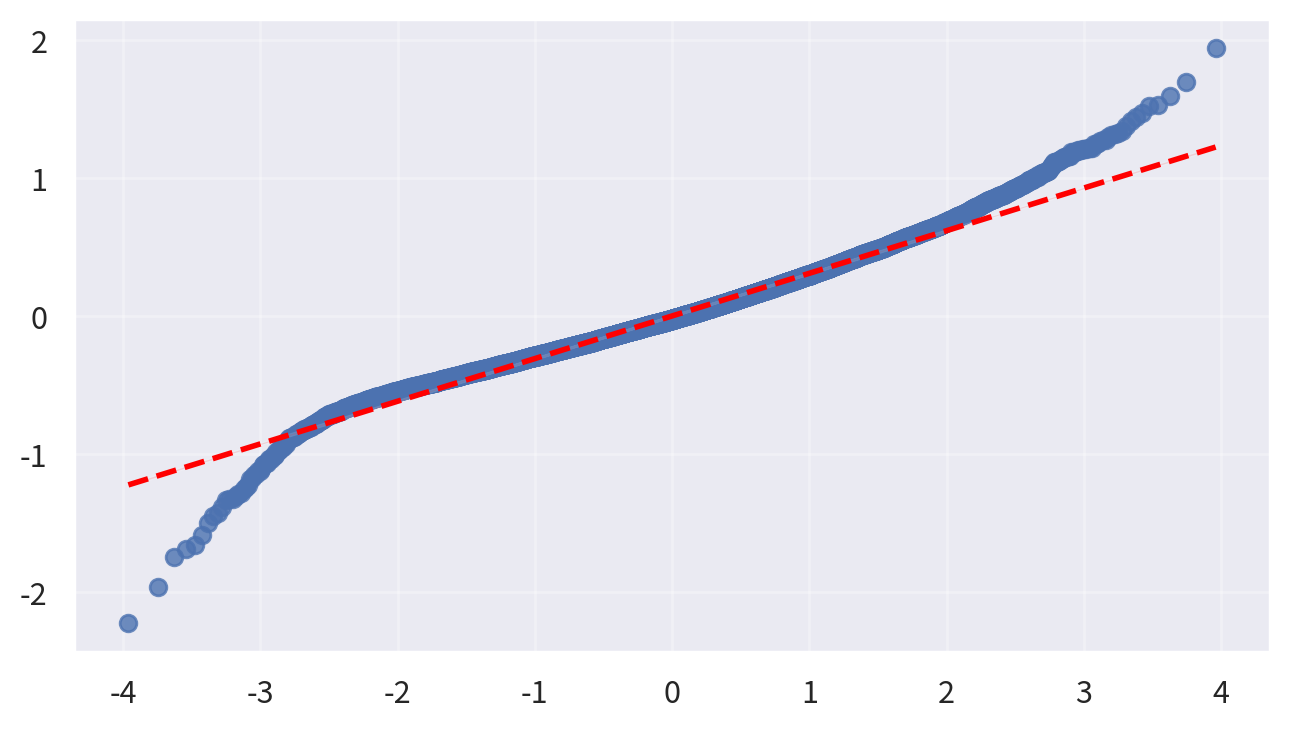

In [55]:
(x, y), _ = probplot(fit.resid)

width_px = 1280
height_px = 720
rows=1
cols=1
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(rows, cols, dpi=my_dpi, figsize=figsize)

sb.regplot(x=x, y=y, line_kws={'color':'red',
                               'linestyle':'--',
                               'linewidth':2
                               })

ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
plt.close()

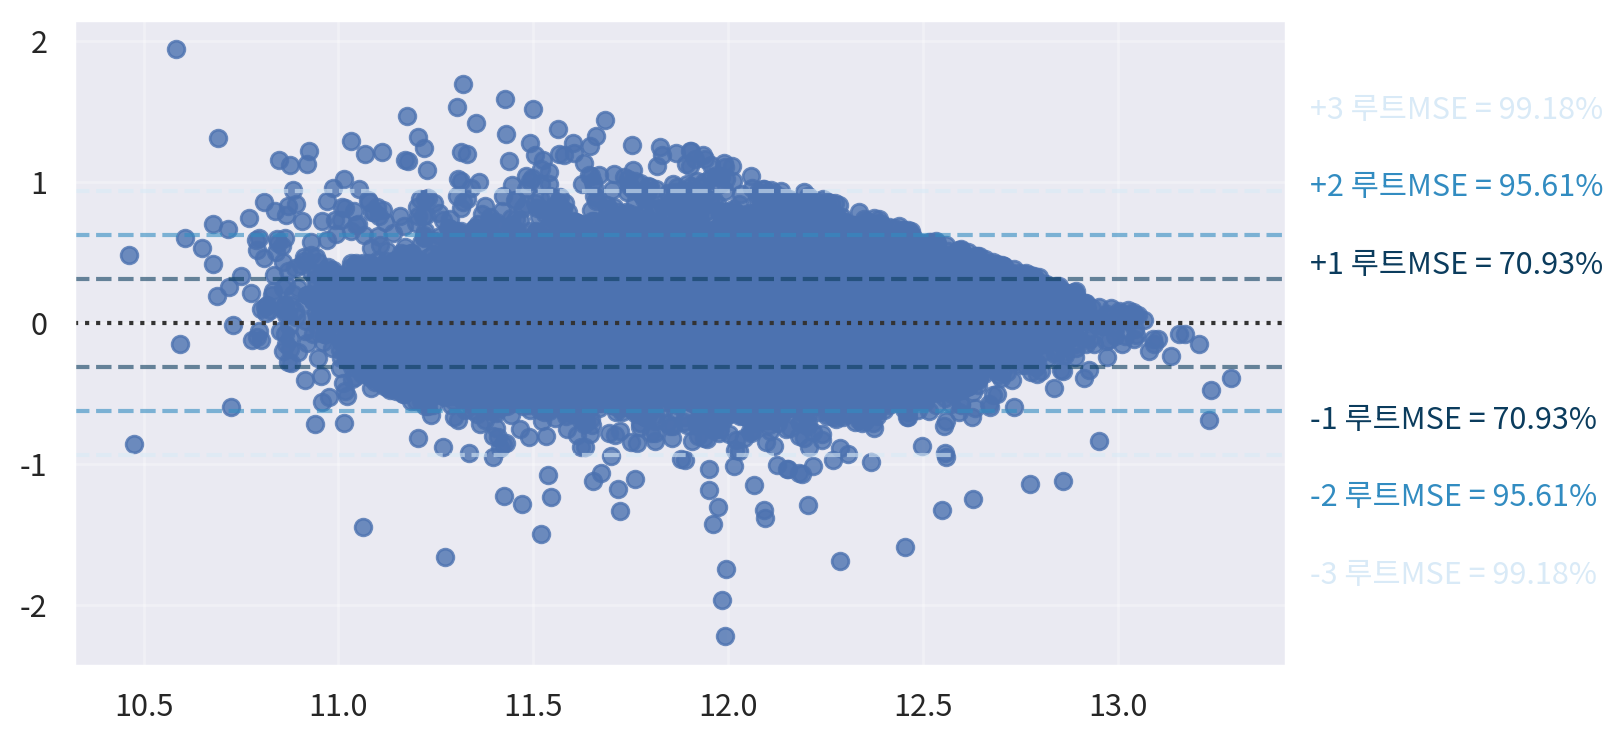

In [56]:
mse_sq = fit.mse_resid
mse_root = np.sqrt(mse_sq)
r = fit.resid       #잔차

r1 = r[(r>-mse_root) & (r<mse_root)].count() / r.count() * 100
r2 = r[(r>-2*mse_root) & (r<2*mse_root)].count() / r.count() * 100
r3 = r[(r>-3*mse_root) & (r<3*mse_root)].count() / r.count() * 100

mse_r = [r1, r2, r3]
colors = ["#0b3C5D", "#328CC1", "#D9EAF7"]

xmax = fit.fittedvalues.max()
ymin = fit.fittedvalues.min()

width_px = 1600
height_px = 720
figsize = (width_px / my_dpi, height_px / my_dpi)
fig, ax = plt.subplots(1, 1, dpi=my_dpi, figsize=figsize, constrained_layout=True)

sb.residplot(x=fit.fittedvalues, y=fit.resid)

ax.grid(True, alpha=0.3)

for i, c in enumerate(colors):
    k= i + 1

    y_pos = k*mse_root
    ax.axhline(y=y_pos, color=c, linestyle="--", alpha=0.6)
    ax.axhline(y=-y_pos, color=c, linestyle="--", alpha=0.6)

    ax.text(x=1.02, y=0.5 + 0.12*k,
            s=f"+{k} 루트MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)
    
    ax.text(x=1.02, y=0.5 - 0.12*k,
            s=f"-{k} 루트MSE = {mse_r[i]:0.2f}%",
            transform=ax.transAxes,
            ha="left", va="center", fontsize=11, color=c)

plt.show()
plt.close()

In [57]:
m

'median_house_value에 대하여 housing_median_age,median_income,nearest_city_dist,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN로 예측하는 회귀분석을 실시한 결과, 이 회귀모형은 통계적으로 유의하다(F(6,18563) = 5827., p <= 0.05).'

In [58]:
print("\n".join(v))

housing_median_age의 회귀계수는 -0.0013(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
median_income의 회귀계수는 0.8609(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
nearest_city_dist의 회귀계수는 -0.0012(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
ocean_proximity_INLAND의 회귀계수는 -0.3361(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
ocean_proximity_NEAR BAY의 회귀계수는 0.0844(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.
ocean_proximity_NEAR OCEAN의 회귀계수는 0.1471(p <= 0.05)로, median_house_value에 대하여 유의한 예측변인인 것으로 나타났다.


### 미션 11. 회귀계수는 무엇을 말해주나?
- 1. 계수(또는 표준화 계수)와 신뢰구간, 방향,크기를 해석
- 2. 소득이 1만달러 늘면 주택 가격이 어떻게 바뀌는가, 주택이 1년 오래될 때마다 가격이 얼마나 떨어지는가 처럼 물리/사회적 의미로 번역
- 3. 변환 변수가 있다면, 변환을 감안한 해석을 명확히 씀
- 4. 표준화 계수(베타)와 비표준화 계수를 병행 제시하고, 단위/변환을 고려한 해석 문장을 명확히 작성
- 5. 위도/경도 계수가 통계적으로 유의하다면, 이것이 지역의 숨은 특성을 어떻게 대리하는지 해석

### 미션 12. 모형 진단과 개선
- 1. 잔차 정규성/등분산/선형성, 영향력을 점검
- 2. R^2, Adj. R^2, RMSE/MAE 등 적합도 지표를 보고하고, 1990년 명목가 기준에서 이 오차가 얼마나 의미 있는지 해석
- 3. 캘리브레이션(예측 vs 실제) 산점도를 함께 제시 예측 구간의 형태를 설명
- 4. 잔차 진단과 적합도 지표를 종합하여 모형의 안정성과 신뢰성을 판단

### 미션 13. 같은 소득인데 왜 가격은 다를까?
- 1. median_income이 같은 두 가상의 지역을 설정하고(예: A 지역은 부유한 해안, B 지역은 외곽), 다른 변수 차이로 가격 차이를 설명
- 2. 비전공자에게 이야기하듯, 모델이 설명하는 것과 못하는 것을 구분해 제시
- 3. 이야기의 흐름을 데이터 관찰 -> 회귀계수 -> 가격 차이 설명 순서로 연결
    - 예시 틀: 두 지역 모두 중위 소득이 $50,000이지만, A 지역은 위도가 높고(해안) 주택이 신축이며 인구밀도가 낮아서... 그래서 모델은 A의 가격을 더 높게 본다. 하지만 이 모델은 학군이나 직장까지의 거리 같은 정보를 담지 못함
- 4. 모델이 설명하지 못한(학군, 질, 교통 접근성, 범죄율, 경제 정책 변화 등)의 가능성도 덧붙여 설득력을 높임